In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from enum import Enum
from colorama import Fore
from datetime import datetime, timedelta
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from sklearn.utils import  resample
from scipy import interpolate
import math
from matplotlib.patches import Rectangle
from scipy import stats

In [181]:
class PlotProperties(Enum):
    figLabelFontSize = 30
    tickLabelFontSize = 18
    axisTitleFontSize = 25
    axisLabelFontDict = {"size":"20","weight":"medium"} 
    axisGridColor = 'white'  
    axisFaceColor = 'gainsboro' 
    axisLegendFontSize = 18
    figFaceColor = 'whitesmoke' 

class TemperatureDataFiles(Enum):
    """
    feedhorn = "data_source/feedhorn_temp_083120.csv"
    outside_aircon = "data_source/outside_aircon_temp_083120.csv"
    rackroom = "data_source/rackroom_temp_083120.csv"
    receiver = "data_source/receiver_temp_083120.csv"
    
    """

    m000 = 'data_source/m000_rsc_rxl_cryocooler_temperature1.csv'
    m004 = 'data_source/m004_rsc_rxl_cryocooler_temperature1.csv'
    m008 = 'data_source/m008_rsc_rxl_cryocooler_temperature1.csv'
    m012 = 'data_source/m012_rsc_rxl_cryocooler_temperature1.csv'
    m016 = 'data_source/m016_rsc_rxl_cryocooler_temperature1.csv'
    m020 = 'data_source/m020_rsc_rxl_cryocooler_temperature1.csv'
    m024 = 'data_source/m024_rsc_rxl_cryocooler_temperature1.csv'
    m028 = 'data_source/m028_rsc_rxl_cryocooler_temperature1.csv'
    m030 = 'data_source/m030_rsc_rxl_cryocooler_temperature1.csv'
    #"""


class HumidityDataFiles(Enum):
    feedhorn = "data_source/feedhorn_hum_083120.csv"
    outside_aircon = "data_source/outside_aircon_hum_083120.csv"
    rackroom = "data_source/rackroom_hum_083120.csv"
    receiver = "data_source/receiver_hum_083120.csv"   

class PhysicalConditions(Enum):
    temp = {
        'name':'Temperature',
        'fileCategory':TemperatureDataFiles,
        'unit':'K',
        'plotColor':'b' 
    }

    hum = {
        'name':'Humidity',
        'fileCategory':HumidityDataFiles,
        'unit':'%RH',
        'plotColor':'b'
    }

def dataVals_for_regrid_timestamp(new_timestamp, old_timestamp, val, interp_kind='slinear'):
    spl = interpolate.interp1d(old_timestamp, val, kind=interp_kind, fill_value="extrapolate")
    return spl(new_timestamp)

def format_axis(ax):
    ax.set_facecolor(PlotProperties.axisFaceColor.value)          
    ax.grid(color=PlotProperties.figFaceColor.value, linestyle = '-', linewidth = 1) 
    ax.tick_params(
        labelsize=PlotProperties.tickLabelFontSize.value,
        colors='dimgrey', rotation=0
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(PlotProperties.axisFaceColor.value)  
          

def adjustPlotView(ax=None,xMin=None,xMax=None,yMin=None,yMax=None):
    if ax==None:
        print(Fore.RED+"\nError! "+Fore.GREEN+"You have not provided the axis object of the plot you want to adjust.\n") #Error Message
        return None,None
    else:
        if not(type(xMin)==int) and not(type(xMin)==float):
            xMin = None
        if not(type(xMax)==int) and not(type(xMax)==float):
            xMax = None
        if not(type(yMin)==int) and not(type(yMin)==float):
            yMin = None
        if not(type(yMax)==int) and not(type(yMax)==float):
            yMax = None

        if not(xMin==None) and not(xMax==None):
            if xMin<xMax: 
                ax.set_xlim(xmin=xMin,xmax=xMax)
            else:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Plot could not be resized due to one or both x-limits entered being invalid. Provide a min value that is less than the max value.\n")    #Error Message

        if not(yMin==None) and not(yMax==None):
            if yMin<yMax: 
                ax.set_ylim(ymin=yMin,ymax=yMax)
            else:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Plot could not be resized due to one or both y-limits entered being invalid. Provide a min value that is less than the max value.\n")    #Error Message
        
        fg = ax.get_figure()
        return fg,ax

def get_plot_fig_ax():
    fg = plt.figure(figsize=(30,10), facecolor=PlotProperties.figFaceColor.value) 
    ax = plt.subplot(1,1,1,facecolor=PlotProperties.axisFaceColor.value)
    format_axis(ax=ax)
    return fg,ax


class SensorDataPlots:
    class SensorData: #Creates an instance of the dataframe and graph for each source file 
        def __init__(self, instanceName, forPhysicalCondition, atSensorLoc, timeDiff, useTimeDiff, timeUnit): 
            self.__phyCond = forPhysicalCondition
            self.__phyCondRef = None
            self.__sensorLoc = atSensorLoc
            self.__df = None 
            self.__ax = None
            self.__refName = instanceName
            self.__use_time_delta = useTimeDiff 
            self.__df_original = None
            self.__time_delta = timeDiff
            self.__timeUnit = timeUnit
            self.__completeInit()

        def __completeInit(self): #loads the data from the source file(s) and prepares it
            dataFileGroup = None
            for j in PhysicalConditions:
                if j.name==self.__phyCond:
                    self.__phyCondRef = j.value
                    dataFileGroup = self.__phyCondRef['fileCategory']
                    break

            dataFile = None
            if dataFileGroup==None:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Data file cannot be located. Make sure you have indicated the data file (with its path).\n") #Error Message
            else:
                for k in dataFileGroup:
                    if k.name==self.__sensorLoc:
                        dataFile = k.value
                        break

            if dataFile==None:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Data file cannot be located. Make sure you have indicated the data file (with its path).\n") #Error Message
            else:
                df = None
                if 'm0' in self.__sensorLoc:
                    df = pd.read_csv(dataFile, header=0, sep=',', usecols=["timestamp","value"])        
                    df.dropna(inplace=True)     #removing any records containing an empty cell
                    df.drop_duplicates(inplace=True)    #removing duplicates in records
                    df.rename(columns={'value':'Value'}, inplace = True)
                    df['timestamp'] = pd.to_numeric(df['timestamp'])
                    df['timestamp'] = [round(df.timestamp[j]) for j in range(len(df))]
                    df.drop_duplicates(subset='timestamp',inplace=True)    #removing duplicates in 'timestamp'
                    oldTmStmp = pd.Series(df.timestamp.values.tolist())
                    df['Date_Time_temp'] = list(map(datetime.fromtimestamp,df['timestamp']))
                    df.set_index('Date_Time_temp', inplace=True)     #setting 'Date_Time' as index
                    df.sort_index(ascending=True, inplace=True) #ensuring the index is sorted, in ascending order
                    
                else:
                    df = pd.read_csv(dataFile, header=18, sep=',', usecols=['Date/Time','Value'], parse_dates=['Date/Time'])  
                    df.dropna(inplace=True)     #removing any records containing an empty cell
                    df.drop_duplicates(inplace=True)    #removing duplicates in records
                    df.rename(columns={'Date/Time':'Date_Time_temp'}, inplace = True)
                    df['timestamp'] = [(df.Date_Time_temp[j]).timestamp() for j in range(len(df))]
                    df['timestamp'] = [round(df.timestamp[j]) for j in range(len(df))]
                    df.drop_duplicates(subset='timestamp',inplace=True)    #removing duplicates in 'timestamp'
                    df.sort_values(by='Date_Time_temp', ascending=True, inplace=True)
                    oldTmStmp = pd.Series(df.timestamp.values.tolist())
                    df.set_index('Date_Time_temp', inplace=True)     #setting 'Date_Time' as index
                    df.sort_index(inplace=True) #ensuring the index is sorted, in ascending order

                self.__df_original = df.copy()
                oldVals = pd.Series(df.Value.values.tolist())
                

                if self.__use_time_delta:
                    #Adjusts dateTime (index values) so that the same time interval (self.__time_delta) is maintained. The
                    # approach used here ensures that any newly added datetime, as long as it is not the same as the last datetime 
                    # in the original dataset, will have a corresponding temperature value the same as that of the immediate dateime 
                    # in the original dataset that this new datetime follows.

                    df = df.asfreq(f'{self.__time_delta}T')  #, method='ffill') #Replace with an interpolation method
                    df['timestamp'] = [(df.index[j]).timestamp() for j in range(len(df))]
                    df['timestamp'] = [round(df.timestamp[j]) for j in range(len(df))]
                    newTmStmp = pd.Series(df.timestamp.values.tolist())
                    newVals = dataVals_for_regrid_timestamp(new_timestamp=newTmStmp, old_timestamp=oldTmStmp, val=oldVals)
                    df['Value'] = [round(x,5) for x in newVals] 
                    tmDelta = (df.iloc[1].name-df.iloc[0].name).total_seconds()/60  #in minutes
                    elapsedTm = [tmDelta*j for j in (range(len(df.index)))]
                    df['Elapsed_Time'] = elapsedTm
                    df['Date_Time'] = list(map(datetime.fromtimestamp,df['timestamp']))
                    df.reset_index(inplace=True, drop=True)
                    df.set_index('Date_Time', inplace=True)
                else:
                    has_uniform_time_interval = self.check_uniform_time_interval(df.index)
                    if has_uniform_time_interval:
                        tmDelta = (df.iloc[1].name-df.iloc[0].name).total_seconds()/60
                        elapsedTm = [tmDelta*j for j in (range(len(df.index)))]
                        df['Elapsed_Time'] = elapsedTm
                        df['Date_Time'] = list(map(datetime.fromtimestamp,df['timestamp']))
                        df.reset_index(inplace=True, drop=True)
                        df.set_index('Date_Time', inplace=True)
                    else:                        
                        df = df.asfreq(f'{self.__time_delta}T')  
                        df['timestamp'] = [(df.index[j]).timestamp() for j in range(len(df))]
                        df['timestamp'] = [round(df.timestamp[j]) for j in range(len(df))]
                        newTmStmp = pd.Series(df.timestamp.values.tolist())
                        newVals = dataVals_for_regrid_timestamp(new_timestamp=newTmStmp, old_timestamp=oldTmStmp, val=oldVals)
                        df['Value'] = [round(x,5) for x in newVals] 
                        tmDelta = (df.iloc[1].name-df.iloc[0].name).total_seconds()/60 #in minutes
                        elapsedTm = [tmDelta*j for j in (range(len(df.index)))]
                        df['Elapsed_Time'] = elapsedTm
                        df['Date_Time'] = list(map(datetime.fromtimestamp,df['timestamp']))
                        df.reset_index(inplace=True, drop=True)
                        df.set_index('Date_Time', inplace=True)
                    
                self.__df = df.copy()
                
        def check_uniform_time_interval(self,checkList)->bool:
            has_uniform_time_interval = True
            if len(checkList)>2:
                for j in range(1,len(checkList)-1): 
                    if not((checkList[j] - checkList[j-1]) == (checkList[j+1] - checkList[j])):
                        has_uniform_time_interval = False
                        break                         
            return has_uniform_time_interval

        def plotData(self, forSingle=True, subPlotIndx=1, subPlots=1):  #Plots the elapsed time and value fields in the the dataframe
            if self.__phyCondRef==None:
                print(Fore.RED+"\nError! "+Fore.GREEN+"You have not indicated a valid physical condition\n")   #Error Message
            else:
                fg = None; ax = None
                nRws = 1; nCols = 3; fgHt = 10
                if forSingle:
                    nCols = 1
                    fg = plt.figure(self.__refName, figsize=(30,10), facecolor=PlotProperties.figFaceColor.value)
                    fg.suptitle("")
                    ax = plt.subplot(nRws,nCols,subPlotIndx)    
                else:
                    if subPlots != 3:
                        nCols = 2
                        nRws = math.trunc(subPlots/nCols) 
                        if nCols*nRws < subPlots:  
                            nRws += 1
                        fgHt = fgHt*nRws

                    fg = plt.figure(self.__refName, figsize=(30,fgHt), facecolor=PlotProperties.figFaceColor.value)
                    ax = plt.subplot(nRws, nCols, subPlotIndx)
                    fg.suptitle(f"{self.__phyCondRef['name']} Reading\n", fontsize=PlotProperties.figLabelFontSize.value,fontweight= "medium")    
                
                plt.cla()
                start_date_time = self.__df.iloc[0].name
                ax.plot(self.__df["Elapsed_Time"], self.__df["Value"], f"{self.__phyCondRef['plotColor']}")
                ax.set_title(f'\n{self.__sensorLoc} (from {start_date_time})', fontdict={"size":PlotProperties.axisTitleFontSize.value})    
                
                if forSingle or math.fmod(subPlotIndx, nCols)==1:
                    ax.set_xlabel(f'Elapsed Time ({self.__timeUnit})',fontdict=PlotProperties.axisLabelFontDict.value)
                    ax.set_ylabel(f"{self.__phyCondRef['name']} ({self.__phyCondRef['unit']})",fontdict=PlotProperties.axisLabelFontDict.value)
                
                format_axis(ax=ax)
                self.__ax = ax
                plt.tight_layout()
                return fg,self.__ax
        
        def adjustPlotView(self,xMin,xMax,yMin,yMax):
            if self.__ax==None:
                print(Fore.RED+"\nError! "+Fore.GREEN+"The plot you are referencing does not exist. Generate the plot before issuing command to adjust it.\n") #Error Message
                return None,None
            else:
                fg,ax = adjustPlotView(self.__ax,xMin=xMin,xMax=xMax,yMin=yMin,yMax=yMax)
                return fg,ax

        def dateTime_of_elapsed_time(self, timeElapsed_in_minutes)->str:
            elapsed_DateTime = None
            upperLmt = self.__df['Elapsed_Time'][-1]
            if timeElapsed_in_minutes<0 or timeElapsed_in_minutes>upperLmt:
                 print(Fore.RED+"\nError! FIRST"+Fore.GREEN+f"The 'timeElapsed_in_minutes' argument provided is invalid. It should be between zero and {upperLmt} inclusive.\n")    #Error Message
            else:
                elapsed_DateTime = self.__df.iloc[0].name + pd.DateOffset(minutes=timeElapsed_in_minutes)
            return elapsed_DateTime
        
        def closest_dateTime_to(self, timeElapsed_in_minutes): 
            dtTmRslt = None
            if type(timeElapsed_in_minutes)==float or type(timeElapsed_in_minutes)==int:
                lowerLmts = (self.__df[self.__df['Elapsed_Time'] <= timeElapsed_in_minutes]['Elapsed_Time']).values.tolist()
                upperLmts = (self.__df[self.__df['Elapsed_Time'] >= timeElapsed_in_minutes]['Elapsed_Time']).values.tolist()
                timeVl = None 

                if len(lowerLmts)==0:
                    timeVl = self.__df['Elapsed_Time'][0]
                elif len(upperLmts)==0:
                    timeVl = self.__df['Elapsed_Time'][-1]
                else:
                    lowerLmt = max(lowerLmts); upperLmt = min(upperLmts)

                    if (timeElapsed_in_minutes-lowerLmt) < (upperLmt-timeElapsed_in_minutes):
                        timeVl = lowerLmt
                    else:
                        timeVl = upperLmt
                dtTmRslt = (self.__df.index[self.__df.Elapsed_Time==timeVl].tolist())[0]
            return dtTmRslt

        def getOriginalData(self):
            return self.__df_original.copy()

        def getTimeDelta(self):
            return self.__time_delta    

        def data_for_elapsedTime_range(self, startTime, endTime):
            rslt = pd.DataFrame(); startTm=None; endTm=None
            if startTime==None and endTime==None:
                rslt = self.__df.copy()
            else:
                startTm_elpsd=None; endTm_elpsd=None
                if startTime==None:
                    startTm_elpsd = 0
                else:
                    startTm_elpsd = startTime

                if endTime==None:
                    endTm_elpsd = self.__df.Elapsed_Time[-1] 
                else:
                    endTm_elpsd = endTime

                if endTm_elpsd>startTm_elpsd:
                    startTm = self.closest_dateTime_to(startTm_elpsd)
                    endTm = self.closest_dateTime_to(endTm_elpsd)
                    rslt = (self.__df[startTm:endTm]).copy()
                else:
                    print(Fore.RED+"\nError! "+Fore.GREEN+f"The 'endTime' argument should be greater than the 'startTime' argument.\n")    #Error Message
            return rslt  
        
        
        def dataModelProps_for(self, timeLimits_in_minutes): 
            dataProps = None
            train = self.data_for_elapsedTime_range(timeLimits_in_minutes[0],timeLimits_in_minutes[1])
            limit1 = timeLimits_in_minutes[1] + self.__time_delta
            limit2 = self.__df['Elapsed_Time'][len(self.__df.index)-1]
            test = self.data_for_elapsedTime_range(limit1,limit2)
            if not(train.empty) and not(test.empty): 
                dataProps = {
                    'train':train,
                    'test':test,
                    'sensorLoc':self.__sensorLoc,
                    'phyCond':self.__phyCond,
                    'phyCondName':self.__phyCondRef['name'],
                    'refName':f"{self.__sensorLoc}_{self.__phyCondRef['name']}",
                    'unit':self.__phyCondRef['unit'],
                    'timeUnit':self.__timeUnit
                }
            else:
                print(Fore.RED+"\nError! "+Fore.GREEN+f"Data set for training or testing could not be created. Kindly ensure you have entered valid values for the 'startTime' and 'endTime' arguments when initiating of the model.\n")    #Error Message
            return dataProps 
        #---End of SensorData (inner) class



    def __init__(self, instanceName, forPhysicalCondition, atSensorLoc='all', timeDiff=10, useTimeDiff=True, timeUnit='min'):
        self.__refName = None                      
        self.__phyCond = None 
        self.__dataFileCategory = None
        self.__sensorLoc = atSensorLoc
        self.__plotsData = dict() 
        self.__completeInit(instanceName, forPhysicalCondition, timeDiff, useTimeDiff, timeUnit)

    def __completeInit(self, rfName, phCnd, timeDiff, useTimeDiff, timeUnit): 
        phCndTest = None
        for cnd in PhysicalConditions:
            if cnd.name==phCnd:
                phCndTest = phCnd
                break

        if phCndTest==None:
            print(Fore.RED+"\nError! "+Fore.GREEN+"The value you entered for the 'forPhysicalCondition' argument is not valid.\n") #Error Message
        else:
            self.__phyCond = phCndTest
            noneTest = "none"
            if isinstance(rfName,str):
                noneTest = rfName.lower()

            if  noneTest=="none" or "":
                print(Fore.RED+"\nError! "+Fore.GREEN+"It is required that you enter a valid instanceName for this method's class object. Kindly use a string that is NOT in ANY FORM of the string 'None'\n") #Error Message
            else:
                self.__refName = rfName 
                for j in PhysicalConditions:
                    if j.name==self.__phyCond:
                        self.__dataFileCategory = j.value['fileCategory']
                        break
                if self.__isOfDataFileCategory:
                    verifiedSensorLoc = self.__verifiedSensorlocation(self.__sensorLoc)
                    if verifiedSensorLoc=='all': 
                        sbPltNdx = 1
                        for loc in self.__dataFileCategory:
                            self.__plotsData[loc.name] = self.SensorData(self.__refName,self.__phyCond,loc.name,timeDiff,useTimeDiff,timeUnit)
                            sbPltNdx += 1
                    elif not(verifiedSensorLoc==None):
                        self.__plotsData[self.__sensorLoc] = self.SensorData(self.__refName,self.__phyCond,verifiedSensorLoc,timeDiff,useTimeDiff,timeUnit) 
                else:
                    print(Fore.RED+"\nError! "+Fore.GREEN+"You have not indicated a valid physical condition.\n") #Error Message
    
    def __hasRefName(self): #This is required to make sure the right plot figure is referenced
        if self.__refName==None: return False
        else: return True

    def __isOfDataFileCategory(self): #This is to ensure the right category of data (whether it is for temperature or humidity) is used in the plots
        if self.__dataFileCategory==None: return False
        else: return True

    def __verifiedSensorlocation(self, atSensorLoc):
        if atSensorLoc=="all":
            if self.__sensorLoc=='all':
                return 'all'
            else:
                sLoc = None
                for loc in self.__dataFileCategory:
                    if loc.name==self.__sensorLoc:
                        sLoc = self.__sensorLoc
                        break
                if sLoc==None:
                    print(Fore.RED+"\nError! "+Fore.GREEN+"You have entered an invalid value for the sensor location.\n")  #Error Message
                    return None
                else:
                    return sLoc
        else:
            sLoc = None
            for loc in self.__dataFileCategory:
                if loc.name==atSensorLoc:
                    sLoc = atSensorLoc
                    break
            if sLoc==None: 
                print(Fore.RED+"\nError! "+Fore.GREEN+"You have entered an invalid value for the sensor location.\n")  #Error Message
                return None
            elif not(sLoc==None) and (self.__sensorLoc=='all' or sLoc==self.__sensorLoc): 
                return sLoc
            else:
                print(Fore.RED+"\nError! "+Fore.GREEN+f"You have entered an invalid value for the sensor location. You should specify the same location you did for the argument 'forPhysicalCondition', when creating the class instance with the instanceName '{self.__refName}'\n")  #Error Message
                return None

    def number_sensor_locations(self):
        return len(self.__plotsData)

    def plotData(self, atSensorLoc="all"): 
        if self.__hasRefName() and self.__isOfDataFileCategory(): 
            verifiedSensorLoc = self.__verifiedSensorlocation(atSensorLoc)   
            if verifiedSensorLoc=='all': 
                fg = None; axs = []
                sbPlts = self.number_sensor_locations()
                sbPltNdx = 1
                for loc in self.__dataFileCategory:
                    mfg, ax = self.__plotsData[loc.name].plotData(forSingle=False, subPlotIndx=sbPltNdx, subPlots=sbPlts)
                    fg = mfg
                    axs.append(ax)
                    sbPltNdx += 1
                return fg,axs
            elif not(verifiedSensorLoc==None):
                fg,ax = self.__plotsData[verifiedSensorLoc].plotData()
                return fg,ax
            else:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Plot could not be generated due to invalid value provided for the sensor location.\n")  #Error Message
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+"Data for plot has not been loaded.\n") #Error Message
    
    def adjustPlotView(self,xMin=None,xMax=None,yMin=None,yMax=None,atSensorLoc="all"):
        verifiedSensorLoc = self.__verifiedSensorlocation(atSensorLoc)
        if self.__hasRefName() and self.__isOfDataFileCategory(): 
            if verifiedSensorLoc=='all':
                self.plotData()
                fg = None; axs = []
                for loc in self.__dataFileCategory:
                    mfg, ax = self.__plotsData[loc.name].adjustPlotView(xMin=xMin,xMax=xMax,yMin=yMin,yMax=yMax)
                    fg = mfg
                    axs.append(ax)
                return fg,axs
            elif not(verifiedSensorLoc==None):
                self.plotData(atSensorLoc=verifiedSensorLoc)
                fg,ax = self.__plotsData[verifiedSensorLoc].adjustPlotView(xMin=xMin,xMax=xMax,yMin=yMin,yMax=yMax)
                return fg,ax
            elif not(verifiedSensorLoc=='all') and not(atSensorLoc==self.__sensorLoc):
                print(Fore.RED+"\nError! "+Fore.GREEN+"Plot view could not be adjusted. Use the same sensor location for which the original plot was created.\n")  #Error Message
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+"The plot you are referencing does not exist.\n") #Error Message

    def get_original_data(self, atSensorLoc="all"):
        rslt = None
        verifiedSensorLoc = self.__verifiedSensorlocation(atSensorLoc)
        if self.__isOfDataFileCategory:
            if verifiedSensorLoc=='all':
                print(Fore.RED+"\nError! "+Fore.GREEN+"You can issue this command for only one sensor location at a time.\n")  #Error Message
            elif not(verifiedSensorLoc==None):
                rslt = self.__plotsData[verifiedSensorLoc].getOriginalData()
            elif not(verifiedSensorLoc=='all') and not(atSensorLoc==self.__sensorLoc):
                print(Fore.RED+"\nError! "+Fore.GREEN+"Sensor data could not be obtained. Use the same sensor location indicated when loading the plot data.\n")  #Error Message
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+"Data has not been loaded.\n") #Error Message
        return rslt 

    def get_data(self, atSensorLoc="all"):  
        rslt = self.get_data_for_elapsedTime_range(atSensorLoc=atSensorLoc)
        return rslt 

    def get_data_for_elapsedTime_range(self, startTime=None, endTime=None, atSensorLoc='all'): 
        rslt = None
        verifiedSensorLoc = self.__verifiedSensorlocation(atSensorLoc)
        if self.__isOfDataFileCategory:
            if verifiedSensorLoc=='all':
                print(Fore.RED+"\nError! "+Fore.GREEN+"You can issue this command for only one sensor location at a time.\n")  #Error Message
            elif not(verifiedSensorLoc==None):
                rslt = self.__plotsData[verifiedSensorLoc].data_for_elapsedTime_range(startTime, endTime)
            elif not(verifiedSensorLoc=='all') and not(atSensorLoc==self.__sensorLoc):
                print(Fore.RED+"\nError! "+Fore.GREEN+"Sensor data could not be obtained. Use the same sensor location indicated when loading the plot data.\n")  #Error Message
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+"Data has not been loaded.\n") #Error Message
        return rslt

    def get_time_delta(self, atSensorLoc='all'):
        rslt = None
        verifiedSensorLoc = self.__verifiedSensorlocation(atSensorLoc)
        if self.__isOfDataFileCategory:
            if verifiedSensorLoc=='all':
                print(Fore.RED+"\nError! "+Fore.GREEN+"You can issue this command for only one sensor location at a time.\n")  #Error Message
            elif not(verifiedSensorLoc==None):
                rslt = self.__plotsData[verifiedSensorLoc].getTimeDelta()
            elif not(verifiedSensorLoc=='all') and not(atSensorLoc==self.__sensorLoc):
                print(Fore.RED+"\nError! "+Fore.GREEN+"Sensor data could not be obtained. Use the same sensor location indicated when loading the plot data.\n")  #Error Message
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+"Data has not been loaded.\n") #Error Message
        return rslt

    def find_elapsed_dateTime(self, forTimeElapsed_in_minutes, atSensorLoc='all'): 
        verifiedSensorLoc = self.__verifiedSensorlocation(atSensorLoc)
        if self.__isOfDataFileCategory:
            if verifiedSensorLoc=='all':
                print(Fore.RED+"\nError! "+Fore.GREEN+"You can issue this command for only one sensor location at a time.\n")  #Error Message
            elif not(verifiedSensorLoc==None):
                elapsed_DateTime = self.__plotsData[verifiedSensorLoc].dateTime_of_elapsed_time(timeElapsed_in_minutes=forTimeElapsed_in_minutes)
                print(Fore.GREEN+f"\nThe Date-time for the Elapsed Time "+Fore.MAGENTA+f"{forTimeElapsed_in_minutes} min(s) "+Fore.GREEN+"is "+Fore.YELLOW+f"{elapsed_DateTime}\n\n")
            elif not(verifiedSensorLoc=='all') and not(atSensorLoc==self.__sensorLoc):
                print(Fore.RED+"\nError! "+Fore.GREEN+"Elapsed Date-time could not be calculated. Use the same sensor location indicated when loading the plot data.\n")  #Error Message
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+"Data has not been loaded.\n") #Error Message

    def get_closest_dateTime(self, toTimeElapsed_in_minutes, atSensorLoc='all'): 
        verifiedSensorLoc = self.__verifiedSensorlocation(atSensorLoc)
        if self.__isOfDataFileCategory:
            if verifiedSensorLoc=='all':
                print(Fore.RED+"\nError! "+Fore.GREEN+"You can issue this command for only one sensor location at a time.\n")  #Error Message
            elif not(verifiedSensorLoc==None):
                elapsed_DateTime = self.__plotsData[verifiedSensorLoc].closest_dateTime_to(timeElapsed_in_minutes=toTimeElapsed_in_minutes)
                return elapsed_DateTime
            elif not(verifiedSensorLoc=='all') and not(atSensorLoc==self.__sensorLoc):
                print(Fore.RED+"\nError! "+Fore.GREEN+"Closest Date-time could not be calculated. Use the same sensor location indicated when loading the plot data.\n")  #Error Message
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+"Data has not been loaded.\n") #Error Message
    #---End of SensorDataPlots class



"""
#COMMANDS TO INITILIZING DATA AND GENERATING FIRST PLOTS
temp_all = SensorDataPlots(
    instanceName="temp_all",    #required argument, and should be unique for each instance of SensorDataPlots created
    forPhysicalCondition=PhysicalConditions.temp.name,  #required argument
    #atSensorLoc=TemperatureDataFiles.feedhorn.name,    #optional argument; if omitted, prepares dataFrames for all sensor locations
    #useTimeDiff=True,  #optional argument; should be bool type
    #timeDiff='10'    #optional argument, should be in minutes; default value of 10 mins is used if useTimeDiff is False and data has unequal time differences. 
) 
temp_all.plotData() #atSensorLoc=TemperatureDataFiles.feedhorn.name) #optional argument
temp_all.adjustPlotView(xMin = None, xMax = None, yMin = 17, yMax = 40) #, atSensorLoc=TemperatureDataFiles.outside_aircon.name  #optional argument; x and y limit values should be int or float type
temp_all.get_Elapsed_DateTime(forTimeElapsed_in_minutes=5000, atSensorLoc=TemperatureDataFiles.feedhorn.name) #obtains the date-tine corresponding to a given elapsed time
"""
print(Fore.WHITE)

Intializing and Visualizing Data for all locations

In [182]:
#--Creates initial DataFrames for sensors of the indicated physical condition at a ALL locations
tempPlot_all = SensorDataPlots(
    instanceName='tempPlot_all',
    forPhysicalCondition=PhysicalConditions.temp.name, 
    #atSensorLoc=TemperatureDataFiles.m028.name,
    timeDiff = 10    #in minutes
) 

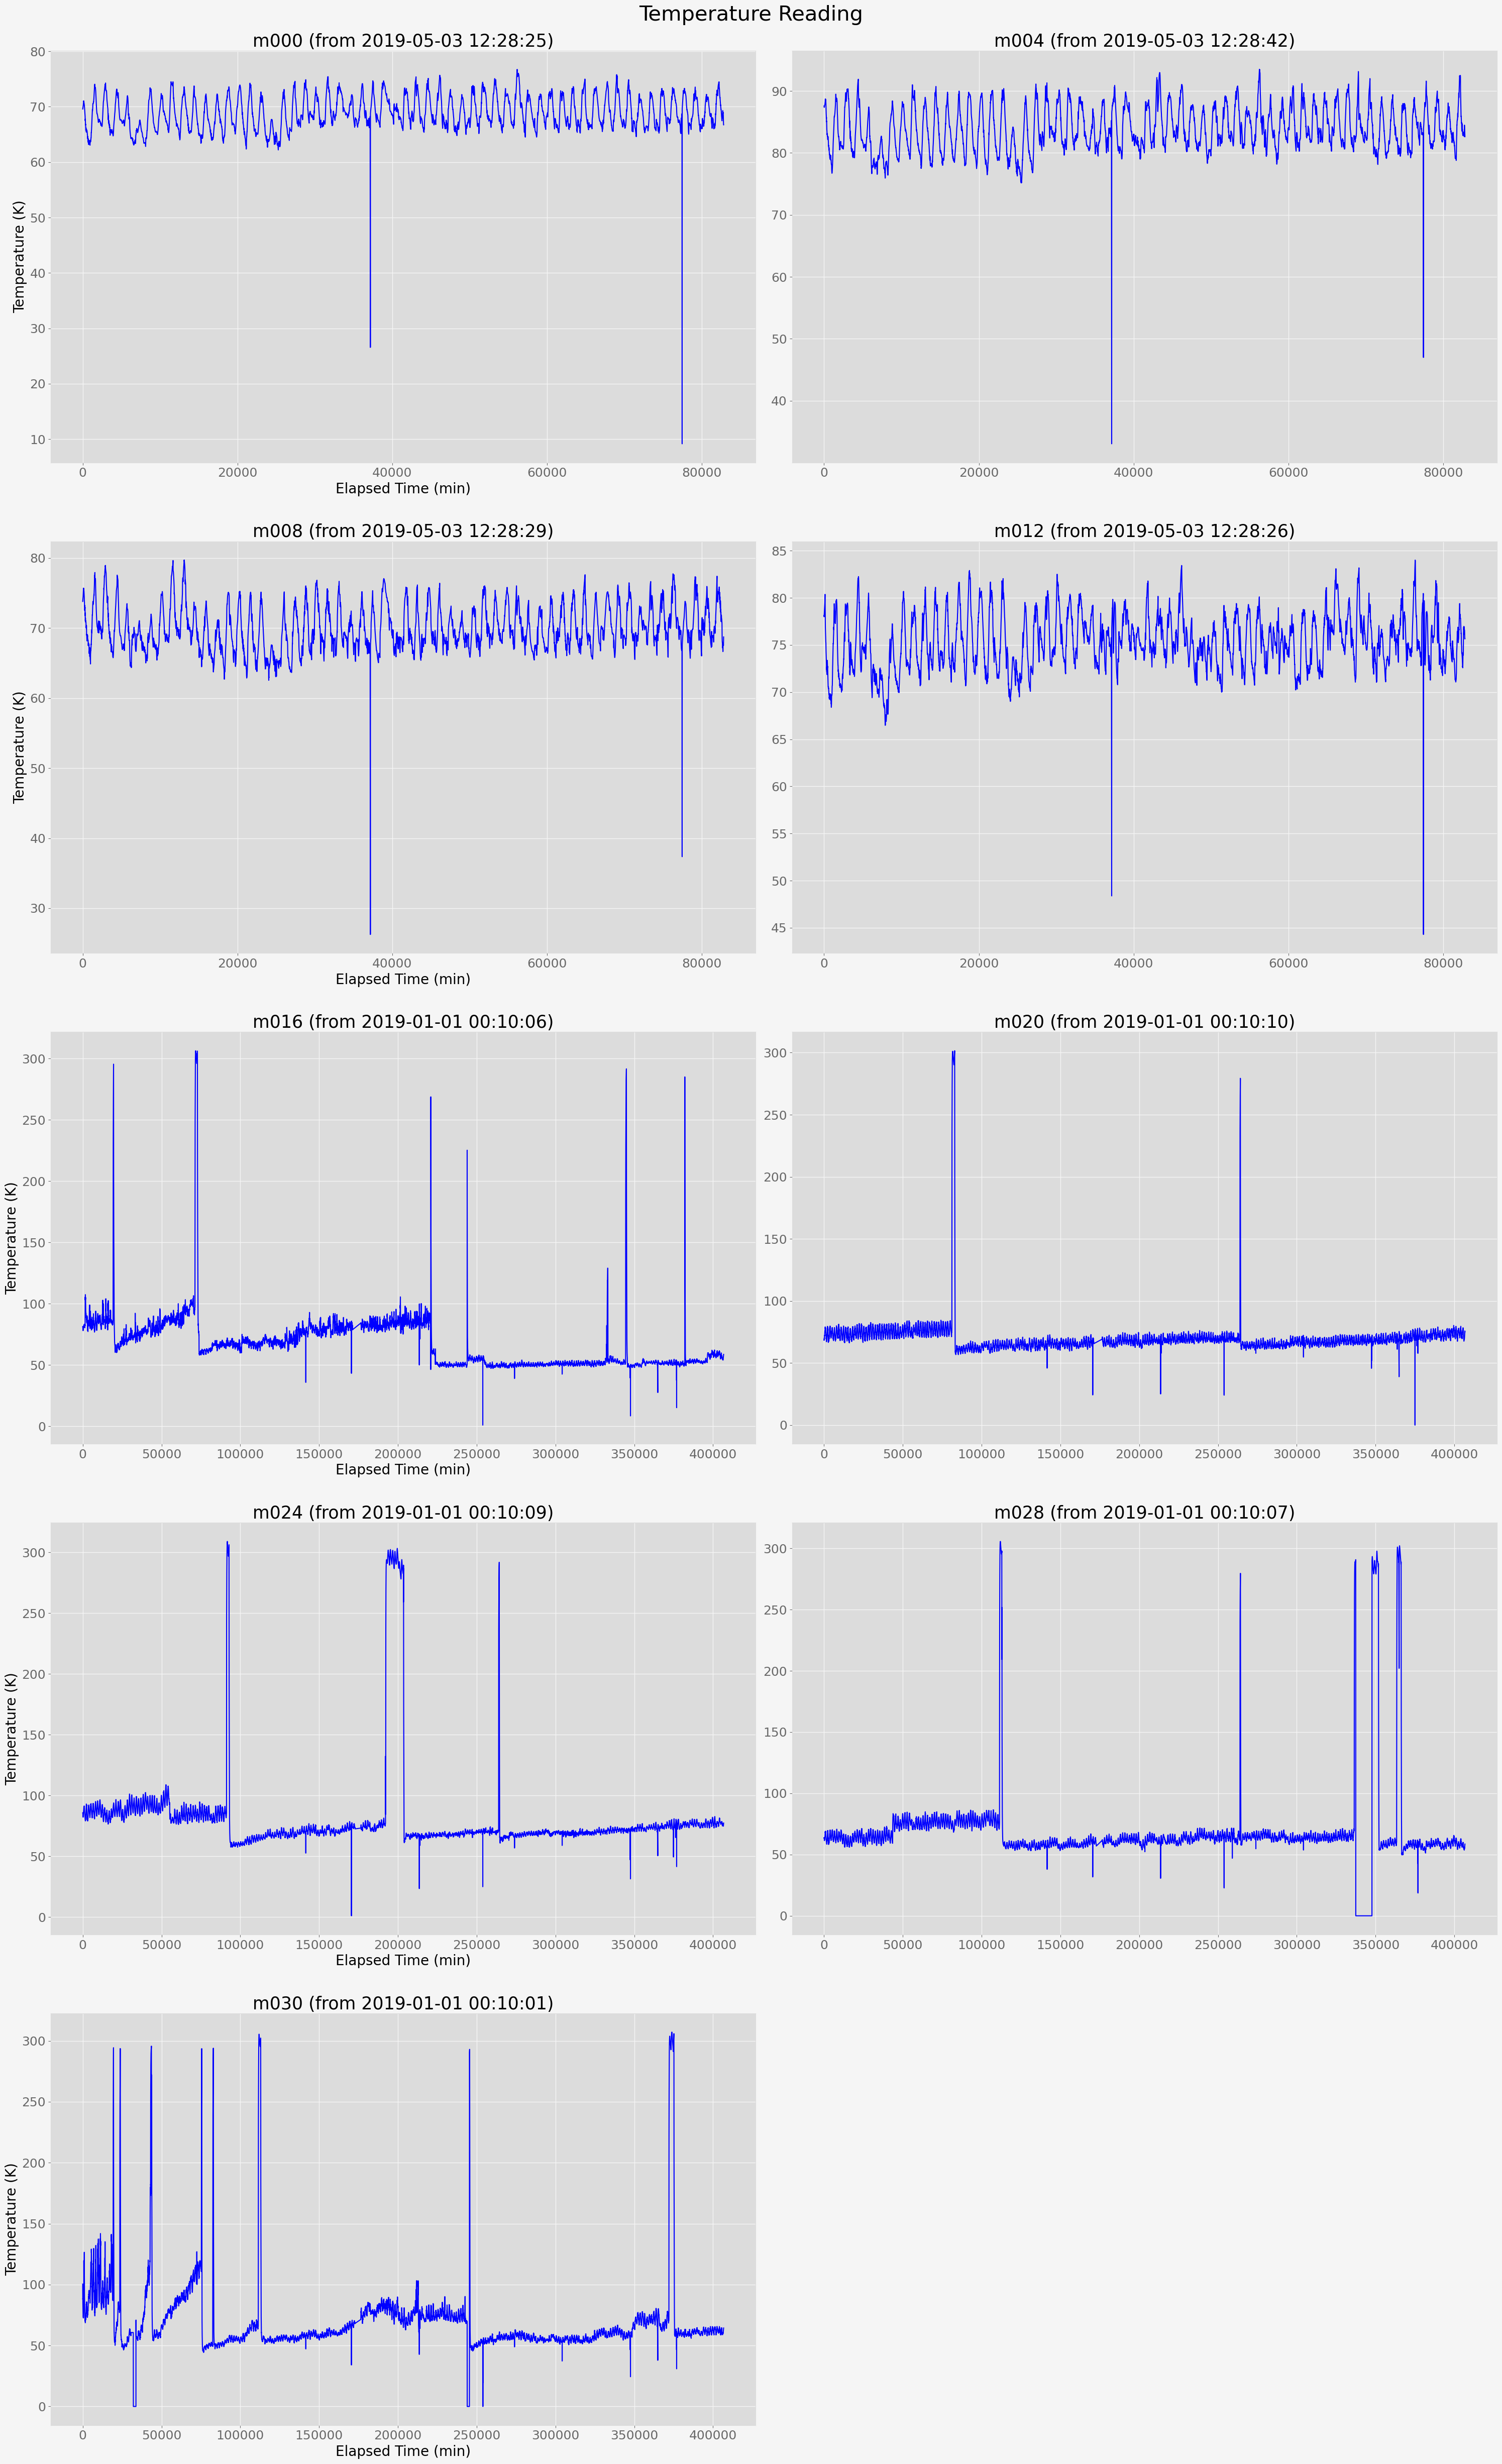

In [183]:
#--Visualizing Original Dataset
fg,axs = tempPlot_all.plotData()
fg.set_size_inches(30,50) 
fg.tight_layout() 

In [184]:
class OutlierDetection:
    def __init__(self, data_for_detection=pd.DataFrame(), ref_data_start_elapsed_time=None, ref_data_end_elapsed_time=None):
        self.__X = np.array([])
        self.__y = np.array([])
        self.__frm_elpsd_time_init = None 
        self.__to_elpsd_time_init = None 
        self.__time_delta = None
        self.__window_size = None
        self.__m_data = pd.DataFrame()   
        self.__ref_data = pd.DataFrame()    #section of self.__m_data used to create the ref_window; it has outliers removed and substituted for by linear interpolation 
        self.__threshold_factor = 1  #used to determine the boundaries for classifying data points as anomalies 
        self.__thresholds = [0,0]    #[lower, upper]
        self.__windowed_data = pd.DataFrame()   #contains partitioned version of the original data using a given time window size    
        self.__bp_data = []     #contains the box-plot data for the iterated removal of outliers in the reference data set
        self.__outlrs = []      #all the outliers detected in the reference data set
        self.__completeInit(mdata=data_for_detection, ref_frm_elpsd_time=ref_data_start_elapsed_time, ref_to_elpsd_time=ref_data_end_elapsed_time)


    def __completeInit(self, mdata, ref_frm_elpsd_time, ref_to_elpsd_time):
        self.__m_data = mdata.copy()
        self.__time_delta = self.__m_data.Elapsed_Time[1] - self.__m_data.Elapsed_Time[0]
        self.__m_data['is_outlier'] = [int(0) for _ in range(len(self.__m_data))]
        self.__create_ref_data(frm_elpsd_time=ref_frm_elpsd_time, to_elpsd_time=ref_to_elpsd_time)
        self.__remove_outliers_in_ref_data()
        self.__replace_outliers_in_ref_data()
        self.__set_thresholds()
        

    def __closest_dateTime_to(self, timeElapsed_in_minutes):
        lowerLmts = (self.__m_data[self.__m_data['Elapsed_Time'] <= timeElapsed_in_minutes]['Elapsed_Time']).values.tolist()
        upperLmts = (self.__m_data[self.__m_data['Elapsed_Time'] >= timeElapsed_in_minutes]['Elapsed_Time']).values.tolist()
        timeVl = None; dtTmRslt = None

        if len(lowerLmts)==0:
            timeVl = self.__m_data['Elapsed_Time'][0]
        elif len(upperLmts)==0:
            timeVl = self.__m_data['Elapsed_Time'][-1]
        else:
            lowerLmt = max(lowerLmts); upperLmt = min(upperLmts)
            if (timeElapsed_in_minutes-lowerLmt) < (upperLmt-timeElapsed_in_minutes):
                timeVl = lowerLmt
            else:
                timeVl = upperLmt
        dtTmRslt = (self.__m_data.index[self.__m_data.Elapsed_Time==timeVl].tolist())[0]
        return dtTmRslt

    
    def __create_ref_data(self, frm_elpsd_time=None, to_elpsd_time=None):
        startDtTm = None; endDtTm = None

        if not(frm_elpsd_time==None):
            startDtTm = self.__closest_dateTime_to(frm_elpsd_time)
        else:
            startDtTm = self.__closest_dateTime_to(self.__m_data.Elapsed_Time[0])   
        
        if not(to_elpsd_time==None):
            endDtTm = self.__closest_dateTime_to(to_elpsd_time) 
        else:
            endDtTm = self.__closest_dateTime_to(self.__m_data.Elapsed_Time[-1]) 

        self.__frm_elpsd_time_init = startDtTm
        self.__to_elpsd_time_init = endDtTm
        self.__ref_data = (self.__m_data[self.__frm_elpsd_time_init:self.__to_elpsd_time_init]).copy()
        self.__ref_data.rename(columns={'is_outlier':'was_outlier'}, inplace = True)        


    """alt
    def __find_outlier(self, in_data):
        data = np.array(in_data)
        q1 = np.quantile(data, 0.25) 
        q3 = np.quantile(data, 0.75)
        med = np.median(data)
        iqr = q3-q1
        upper_bound = q3+(1.5*iqr)
        lower_bound = q1-(1.5*iqr)
        outlrs = np.array(list(data[(data < lower_bound)]) + list(data[(data > upper_bound)]))
        if outlrs.size == 0:
            return None
        else:
            return outlrs.max()
    """
    def __find_outlier(self, in_data):       
        def find_outliers_in_data(data):     
            data = np.array(data)
            q1 = np.quantile(data, 0.25) 
            q3 = np.quantile(data, 0.75)
            iqr = q3-q1
            upper_bound = q3+(1.5*iqr)
            lower_bound = q1-(1.5*iqr)
            lower_outlrs = data[(data < lower_bound)] 
            upper_outlrs = data[(data > upper_bound)]  
            return [lower_bound, upper_bound], [lower_outlrs, upper_outlrs]
        
        bounds, outlrs = find_outliers_in_data(data=in_data)  
        min_outlr = None; max_outlr = None; outlr = None  
        if not(len(outlrs[0])==0):
            min_outlr = outlrs[0].min()
        if not(len(outlrs[1])==0):
            max_outlr = outlrs[1].max()
        
        if not(min_outlr==None) and not(max_outlr==None):
            if (min(bounds)-min_outlr) > (max_outlr-max(bounds)):
                outlr = min_outlr
            else:
                outlr = max_outlr
        elif not(min_outlr==None):
            outlr = min_outlr; 
        elif not(max_outlr==None):
            outlr = max_outlr
        return outlr
    #"""


    def __remove_outliers_in_ref_data(self, confirm_count=10): 
        print("\nLOCATING OUTLIERS IN Reference dataset... waiting for last iteration")
        find_next_outlr = True; cnt = 0; exitCount = 0
        self.__bp_data = []; self.__outlrs = []

        while find_next_outlr:  
            data_without_outliers = self.__ref_data[self.__ref_data.was_outlier == 0]
            b_sz = int(0.8*len(data_without_outliers))  
            b_sample = resample(data_without_outliers.Value.values.tolist(), replace=True, n_samples=b_sz) #, random_state=1)
            print(f"Iteration {cnt+1}")
            outlr = self.__find_outlier(in_data=b_sample) 
            cnt += 1            

            if outlr != None:
                self.__outlrs.append(outlr)
                self.__bp_data.append(b_sample)
                
                dta_with_outliers = self.__ref_data[self.__ref_data.Value == outlr]
                for j in dta_with_outliers.Elapsed_Time.values.tolist():
                    self.__ref_data.loc[self.__ref_data['Elapsed_Time']==j, 'was_outlier'] = int(1)
                
                dta_with_outliers = self.__m_data[self.__m_data.Value == outlr]
                for j in dta_with_outliers.Elapsed_Time.values.tolist():
                    self.__m_data.loc[self.__m_data['Elapsed_Time']==j, 'is_outlier'] = int(1)

                exitCount = 0
            else:
                exitCount += 1
                if exitCount > confirm_count:
                    find_next_outlr = False
        
        print(f"Last Iteration is {cnt}")
         
        if len(self.__ref_data[self.__ref_data.was_outlier==1])>0:
            print("\nREMOVING OUTLIER VALUES IN Reference dataset...")
            self.__ref_data.loc[self.__ref_data['was_outlier']==1, 'Value'] = np.NaN 
            print("Finished removing outlier values in Reference dataset...")
        else:
            print("No outliers found in Reference dataset.")    
    

    def __prep_boxplots(self): 
        fg = plt.figure(figsize=(20, 20))
        ax = fg.add_axes([0,0,1,1])
        format_axis(ax)
        return fg,ax


    def __set_time_window_size(self, window_size):
        rtnVl = None
        win_sz = int(window_size)
        if (win_sz/self.__time_delta) >= 1:
            self.__window_size = win_sz
            rtnVl = self.__window_size
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"The window_size argument {window_size} provided is invalid. Provide one that is at least {self.__time_delta}.\n") #Error Message
        return rtnVl


    def __replace_outliers_in_ref_data(self):   #uses a linear interpolation technique 
        ref_data_outlrs = self.__ref_data[self.__ref_data.was_outlier==1]
        if len(ref_data_outlrs) > 0:
            print("\nREPLACING OUTLIER VALUES IN Reference dataset...")
            tm_del = self.__time_delta
            rfDt_nan = self.__ref_data[self.__ref_data['Value'].isna()]
            rfDt_nt_nan = self.__ref_data[self.__ref_data['Value'].notna()]
            if rfDt_nan.Elapsed_Time[0]==self.__ref_data.Elapsed_Time[0]:
                self.__ref_data.loc[self.__ref_data['Elapsed_Time']==rfDt_nan.Elapsed_Time[0], 'Value'] = rfDt_nt_nan.Value[0] 
                rfDt_nan = self.__ref_data[self.__ref_data['Value'].isna()]
                rfDt_nt_nan = self.__ref_data[self.__ref_data['Value'].notna()]
        
            while not(rfDt_nan.empty):                
                if rfDt_nan.Elapsed_Time[0]==self.__ref_data.Elapsed_Time[-1]:
                    self.__ref_data.loc[self.__ref_data.Elapsed_Time==(rfDt_nt_nan.Elapsed_Time[-1]), 'Value'] = rfDt_nt_nan.Value[-1]
                else:
                    elpsd_tm_1 = rfDt_nan.Elapsed_Time[0] - tm_del
                    elpsd_tm_2 = rfDt_nt_nan[rfDt_nt_nan.Elapsed_Time<(elpsd_tm_1+tm_del)].Elapsed_Time[-1]
                    rfDt_nt_nan_chk = rfDt_nt_nan[rfDt_nt_nan.Elapsed_Time>(elpsd_tm_1+tm_del)]
                    if len(rfDt_nt_nan_chk)>0:
                        elpsd_tm_2 = rfDt_nt_nan_chk.Elapsed_Time[0]
                        vl_1 = self.__ref_data[self.__ref_data.Elapsed_Time==elpsd_tm_1].Value[0]
                        vl_2 = self.__ref_data[self.__ref_data.Elapsed_Time==elpsd_tm_2].Value[0]
                        grdnt = (vl_2-vl_1)/(elpsd_tm_2-elpsd_tm_1)
                        for j in range(int((elpsd_tm_2-elpsd_tm_1)/tm_del)-1):
                            n_vl = grdnt*tm_del*(j+1) + vl_1
                            self.__ref_data.loc[self.__ref_data.Elapsed_Time==(elpsd_tm_1+tm_del*(j+1)), 'Value'] = n_vl
                    else:
                        n_vl = self.__ref_data[self.__ref_data.Elapsed_Time==elpsd_tm_2].Value[0]
                        for j in range(len(rfDt_nan)):
                            self.__ref_data.loc[self.__ref_data.Elapsed_Time==rfDt_nan.Elapsed_Time[j], 'Value'] = n_vl

                rfDt_nan = self.__ref_data[self.__ref_data['Value'].isna()]
                rfDt_nt_nan = self.__ref_data[self.__ref_data['Value'].notna()]
            print(f"Outlier values in Reference dataset replaced")
        else:
            print("\nNo outliers present in Reference dataset")


    def __create_windowed_data(self):
        print("\nCREATING windowed data...")
        win_sz = self.__window_size
        minVl = (self.__m_data.Elapsed_Time[0]).astype(int)        
        windowed_data_ndx = [(minVl+(win_sz*j)) for j in range((int(math.trunc(self.__m_data.Elapsed_Time[-1] - minVl)/win_sz) + 1))]        
        windowed_data = pd.DataFrame(windowed_data_ndx, columns=['window_start'])
        for_tm_stamp = []
        
        for j in windowed_data.window_start.values.tolist():
            for_tm_stamp.append((self.__m_data.timestamp[self.__m_data['Elapsed_Time']==j].tolist())[0])    
        
        windowed_data['Date_Time'] = list(map(datetime.fromtimestamp,for_tm_stamp))
        windowed_data.set_index('Date_Time', inplace=True)     
        windowed_data.sort_index(ascending=True, inplace=True)
        self.__windowed_data = windowed_data
        print("Windowed data created")
        self.__count_outliers_in_windowed_data() 


    def __set_thresholds(self):
        ref_data_range = max(self.__ref_data.Value) - min(self.__ref_data.Value)
        thold_diff = ref_data_range * self.__threshold_factor
        self.__thresholds = [(min(self.__ref_data.Value)-thold_diff), (max(self.__ref_data.Value)+thold_diff)]
        self.__determine_outliers_in_dataset()


    def __determine_outliers_in_dataset(self):
        print("\nLOCATING OUTLIERS IN DATASET...")
        m_data_elpsdTms = self.__m_data.Elapsed_Time.values.tolist()
        m_data_elpsdTm_0 = m_data_elpsdTms[0]

        for j in m_data_elpsdTms:
            dataVal_ndx = int((j-m_data_elpsdTm_0)/self.__time_delta)
            dataVal = self.__m_data.Value[dataVal_ndx]
            if dataVal<self.__thresholds[0] or dataVal>self.__thresholds[1]:
                self.__m_data.loc[self.__m_data['Elapsed_Time']==j, 'is_outlier'] = int(1)
            else:
                self.__m_data.loc[self.__m_data['Elapsed_Time']==j, 'is_outlier'] = int(0) 
        print("Finished locating outliers in dataset")


    def __count_outliers_in_windowed_data(self):
        print("\nCOUNTING OUTLIERS IN WINDOWED DATA...")
        self.__windowed_data['num_of_outliers'] = [int(0) for _ in range(len(self.__windowed_data))]
        self.__windowed_data['has_outliers'] = [int(0) for _ in range(len(self.__windowed_data))]
        win_start_vals = self.__windowed_data.window_start.values.tolist()

        for j in win_start_vals:
            vals_to_count_df = self.__m_data[self.__m_data.Elapsed_Time>=j]
            vals_to_count_df = vals_to_count_df[vals_to_count_df.Elapsed_Time < (j + self.__window_size)]
            vals_to_count_df = vals_to_count_df[vals_to_count_df.is_outlier==1]
            self.__windowed_data.loc[self.__windowed_data['window_start']==j, 'num_of_outliers'] = len(vals_to_count_df)
            
            if len(vals_to_count_df)>0:
                self.__windowed_data.loc[self.__windowed_data['window_start']==j, 'has_outliers'] = int(1)
        print("Finished counting outliers in windowed data...")


    def create_windowed_data(self, with_window_size=None):
        if not(with_window_size==None) and (with_window_size >= self.__time_delta):
            win_sz = self.__set_time_window_size(window_size=with_window_size)
            if not(win_sz==None):
                self.__create_windowed_data()
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"Enter a valid time window that is at least {self.__time_delta} minutes or a multiple of {self.__time_delta} minutes.\n") #Error Message


    def adjust_threshold_factor(self, factor):
        if factor >= 0:
            self.__threshold_factor = factor
            self.__set_thresholds()
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"Invalid threshold factor. Provide a value that is greater than or equal to zero.\n") #Error Message


    def get_threshold_factor(self):
        return self.__threshold_factor

    def get_thresholds(self):
        return self.__thresholds
    
    def get_reference_data(self):
        return self.__ref_data

        
    def get_windowed_data(self):
        if self.__windowed_data.empty:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"No windowed data created. Create one first (by setting a window size) before issuing this command.\n") #Error Message
        else:
            return self.__windowed_data
    

    def get_original_data(self):
        return self.__m_data


    def get_time_delta(self):
        return self.__time_delta


    def get_time_window_size(self):
        if self.__window_size==None:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"No windowed data created. Create one first (by setting a window size) before issuing this command.\n") #Error Message
        else:
            return self.__window_size
        

    def get_boxplot_data(self):
        if len(self.__bp_data)==0:
            self.__remove_outliers_in_ref_data()
            return self.__bp_data, self.__outlrs
        else:
            return self.__bp_data, self.__outlrs


    def plot_thresholds(self, on_axis, lower_threshold_color, upper_threshold_color):
        _ = on_axis.hlines(
            y=self.__thresholds[0], 
            xmin=self.__m_data.Elapsed_Time[0], 
            xmax=self.__m_data.Elapsed_Time[-1],
            linestyles='dashed',
            colors=[lower_threshold_color],
            label='lower threshold'
        )

        _ = on_axis.hlines(
            y=self.__thresholds[1], 
            xmin=self.__m_data.Elapsed_Time[0], 
            xmax=self.__m_data.Elapsed_Time[-1],
            linestyles={'dashed'},
            colors=[upper_threshold_color],
            label='upper threshold'
        )        


    def plot_outliers_in_reference_data(self, on_axis, plotColor, plotMarker='o'):
        #Obtaning outliers of reference data, before their removal
        rfDt_outlrs_elpsdTm = self.__ref_data[self.__ref_data.was_outlier==1]['Elapsed_Time'].values.tolist()
        rfDt_outlrs_df = self.__m_data.loc[self.__m_data['Elapsed_Time'].isin(rfDt_outlrs_elpsdTm)]
        _ = on_axis.plot(rfDt_outlrs_df.Elapsed_Time, rfDt_outlrs_df.Value, color=plotColor, linestyle='', marker=plotMarker, label='previous outliers in ref data')


    def plot_boxplots(self, start_ndx = 0, end_ndx = -1, step_sz = 1):
        if len(self.__bp_data)==0:
            self.__remove_outliers_in_ref_data()            

        if len(self.__bp_data) > 0:
            max_ndx = len(self.__bp_data)
            if start_ndx<0:
                start_ndx = max_ndx - abs(start_ndx)
            if end_ndx<0:
                end_ndx = max_ndx - abs(end_ndx)

            if (start_ndx < end_ndx) and (start_ndx < max_ndx) and step_sz >= 1: 
                fg,ax = self.__prep_boxplots()
                fg.set_size_inches(20,7.5)
                ax.set_title('Bootstrapped Samples', fontdict={"size":PlotProperties.axisTitleFontSize.value})
                ax.set_xlabel('Iteration', fontdict=PlotProperties.axisLabelFontDict.value)  
                ax.set_ylabel('Temperature [K]', fontdict=PlotProperties.axisLabelFontDict.value)
                xtcklbs = [f"{x+1}" for x in range(start_ndx, max_ndx, step_sz)]
                _ = ax.boxplot(self.__bp_data[start_ndx:end_ndx:step_sz], showmeans=True)
                ticks_loc = [(x+1) for x in range(len(xtcklbs))]  #ax.get_xticks().tolist()
                ax.xaxis.set_major_locator(mticker.FixedLocator(locs=ticks_loc, nbins=len(ticks_loc)))
                ax.set_xticklabels(xtcklbs)
                return fg,ax
            elif start_ndx >= max_ndx:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Invalid arguments. Index out of range.\n")    #Error Message
                return None,None
            elif start_ndx>=end_ndx:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Invalid arguments. start_ndx should be less than end_ndx.\n")    #Error Message
                return None,None
            else:
                print(Fore.RED+"\nError! "+Fore.GREEN+"Invalid arguments. step_sz should be greater than or equal to 1.\n")    #Error Message
                return None,None
        else:
            print(Fore.GREEN+"No box plot data available. The initial reference dataset did not have any outliers.\n")    #Error Message
            return None,None


    def plot_data(self,plot_fg=None, plot_ax=None):
        fg = plot_fg; ax = plot_ax
        if fg==None or ax==None:
            fg,ax = get_plot_fig_ax()
        ax.set_ylabel('Temperature (K)')
        ax.set_xlabel('Elapsed Time (min)')
        ax.plot(self.__m_data.Elapsed_Time, self.__m_data.Value, marker='', linestyle='-', color='b', label='original data')
        ax.legend(loc='best')
        return fg,ax

    def plot_outliers(self, plot_fg=None, plot_ax=None):
        fg = plot_fg; ax = plot_ax

        if fg==None or ax==None:
            fg,ax = get_plot_fig_ax()
        
        outlrs_data = self.get_outliers()
        ax.set_title('Outliers')
        ax.plot(outlrs_data.Elapsed_Time, outlrs_data.Value, marker='o', color='r', linestyle='', label='outliers')
        ax.legend(loc='best')
        fg.tight_layout()
        return fg,ax


    def get_outliers(self):
        outlrs_data = self.__m_data[self.__m_data.is_outlier == 1]
        return outlrs_data.copy()
                

    def show_windowed_data(self, from_date_time=None, to_date_time=None, on_ax=None, with_fg=None, show_outliers=False, show_counts=False, adjust_plot_to={'xMin':None, 'xMax':None, 'yMin':None, 'yMax':None}): 
        if not(self.__windowed_data.empty):
            win_sz = self.__window_size
            n_windowed_data = self.__windowed_data 

            if from_date_time != None: 
                n_windowed_data = n_windowed_data[n_windowed_data.index >= from_date_time]
            if to_date_time != None: 
                n_windowed_data = n_windowed_data[n_windowed_data.index <= to_date_time]

            if not(n_windowed_data.empty):
                fg,ax = self.plot_data(plot_fg=with_fg, plot_ax=on_ax)
                if show_outliers:
                    self.plot_outliers(plot_fg=fg, plot_ax=ax)

                mrgn = self.__time_delta/2
                maxVl = max(self.__m_data.Value.values.tolist())
                minVl = min(self.__m_data.Value.values.tolist())

                clrStrs = ['lightsteelblue', 'aliceblue']    
                clrStrs_sz = len(clrStrs)
                outlr_counts = {}; xMinVal = 0; xMaxVal = 0
                outlr_count_txt_props = []

                for j in range(len(n_windowed_data)):
                    win_l_bound = n_windowed_data.window_start[j]
                    outlr_counts[f'{win_l_bound}'] = (n_windowed_data[n_windowed_data.window_start==win_l_bound]).num_of_outliers[0]
                    fclr_ndx = int(math.fmod(j,clrStrs_sz))
                    ax.add_patch(
                        Rectangle(
                            (win_l_bound-mrgn, minVl-5), win_sz, (maxVl-minVl)+10,
                            edgecolor = 'none',
                            facecolor = clrStrs[fclr_ndx],
                            alpha=1,
                            fill=True,
                            lw=1
                        )
                    )
                    outlr_count_txt_props.append({
                        'x' : win_l_bound-mrgn+(win_sz/2),
                        'y' : maxVl+12,
                        's' : f"{outlr_counts[f'{win_l_bound}']}"
                    })

                    if j==0: xMinVal = win_l_bound - win_sz 
                    if j==(len(n_windowed_data)-1): xMaxVal = win_l_bound + win_sz + win_sz         

                yMinVal=minVl-10; yMaxVal=maxVl+50
                xMn=adjust_plot_to['xMin']; xMx=adjust_plot_to['xMax']; yMn=adjust_plot_to['yMin']; yMx=adjust_plot_to['yMax']
                if xMn != None: xMinVal = xMn
                if xMx != None: xMaxVal = xMx
                if yMn != None: yMinVal = yMn
                if yMx != None: yMaxVal = yMx                
                fg,ax = adjustPlotView(ax=ax, xMin=float(xMinVal), xMax=float(xMaxVal), yMin=float(yMinVal), yMax=float(yMaxVal))

                if show_counts:
                    for txt_prp in outlr_count_txt_props:
                        txt_prp_x=txt_prp['x']; txt_prp_y=txt_prp['y']
                        if float(txt_prp_x)>xMinVal and txt_prp_x<xMaxVal and txt_prp_y<yMaxVal:
                            ax.text(
                                x=txt_prp_x, y=txt_prp_y, s=txt_prp['s'], 
                                fontdict={"size":"12","weight":"medium"},
                                horizontalalignment='center', 
                                verticalalignment='center'
                            )
                
                return fg,ax    #,outlr_counts
            else:
                print(Fore.RED+"\nError! "+Fore.GREEN+f"You have no data in the date-time limits provided. 'to_date_time' should be at least {win_sz} mins later than 'from_date_time', in comformity to the windowed data set.\n") #Error Message
                return None,None
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"No windowed data created. Create one first (by setting a window size) before issuing this command.\n") #Error Message
            return None,None


    def show_plots_in_window(self, from_date_time=None, to_date_time=None, on_ax=None, with_fg=None, show_outliers=False, show_counts=False, adjust_plot_to={'xMin':None, 'xMax':None, 'yMin':None, 'yMax':None}):                
        n_data = self.__m_data

        if from_date_time != None: 
            n_data = n_data[n_data.index >= from_date_time]        
        if to_date_time != None: 
            n_data = n_data[n_data.index <= to_date_time]

        if not(n_data.empty):
            strtTm_elpsd = n_data.Elapsed_Time[0]
            endTm_elpsd = n_data.Elapsed_Time[-1]
        
            maxVl = max(self.__m_data.Value.values.tolist())
            minVl = min(self.__m_data.Value.values.tolist())
            num_of_outlrs = len(n_data[n_data.is_outlier==1])

            fg,ax = self.plot_data(plot_fg=with_fg, plot_ax=on_ax)
            if show_outliers:
                self.plot_outliers(plot_fg=fg, plot_ax=ax)

            ax.add_patch(
                Rectangle(
                    (strtTm_elpsd, minVl-5), (endTm_elpsd-strtTm_elpsd), (maxVl-minVl)+10,
                    edgecolor = 'none',
                    facecolor = 'lightsteelblue',
                    alpha=1,
                    fill=True,
                    lw=1
                )
            )

            mrgn = 0.015*(endTm_elpsd-strtTm_elpsd)
            xMinVal = strtTm_elpsd - mrgn 
            xMaxVal = endTm_elpsd + mrgn 
            yMinVal = minVl-10; yMaxVal = maxVl+50
            xMn=adjust_plot_to['xMin']; xMx=adjust_plot_to['xMax']; yMn=adjust_plot_to['yMin']; yMx=adjust_plot_to['yMax']
            if xMn != None: xMinVal = xMn
            if xMx != None: xMaxVal = xMx
            if yMn != None: yMinVal = yMn
            if yMx != None: yMaxVal = yMx                
            fg,ax = adjustPlotView(ax=ax, xMin=float(xMinVal), xMax=float(xMaxVal), yMin=float(yMinVal), yMax=float(yMaxVal))

            if show_counts:
                txt_prp_x = strtTm_elpsd+((endTm_elpsd-strtTm_elpsd)/2); txt_prp_y = maxVl+12
                if float(txt_prp_x)>xMinVal and txt_prp_x<xMaxVal and txt_prp_y<yMaxVal:
                    ax.text(
                        x=txt_prp_x, y=txt_prp_y, s=f"{num_of_outlrs}", 
                        fontdict={"size":"12","weight":"medium"},
                        horizontalalignment='center', 
                        verticalalignment='center'
                    )
            
            return fg,ax,num_of_outlrs
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"You have no data in the date-time limits provided. 'to_date_time' should be at least {self.__time_delta} mins later than 'from_date_time', in comformity to the data set.\n") #Error Message
            return None,None,None

    def plot_class_distribution(self):
        if not(self.__windowed_data.empty):
            pieChartData = []
            myLbls = ['Without Outliers', 'With Outliers']
            pieChartData.append(len(self.__windowed_data[self.__windowed_data.has_outliers==0]))
            pieChartData.append(len(self.__windowed_data[self.__windowed_data.has_outliers==1]))

            fg,ax = plt.subplots()
            fg.set_facecolor(PlotProperties.axisFaceColor.value)
            fg.set_size_inches(8,6)
            ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            ax.pie( 
                pieChartData, 
                autopct='%1.1f%%', pctdistance=0.7, 
                labels=myLbls, labeldistance=None,
                explode=(0, 0.05),
                wedgeprops=dict(width=0.6, edgecolor=fg.get_facecolor(), linewidth=1),
                textprops=dict(color="w", font=dict(size=15, weight='semibold'))
                #radius=1
                #colors=colors,
            )
            _ = ax.legend()
            return fg,ax
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"No windowed data created. Create one first (by setting a window size) before issuing this command.\n") #Error Message
            return None,None

        
    def create_data_features(self):
        if not(self.__windowed_data.empty):
            windowed_features = []
            rng = len(self.__windowed_data)
            for j in range(rng-1):
                n_df = self.__m_data[self.__m_data.Elapsed_Time >= self.__windowed_data.iloc[j].window_start]
                n_df = n_df[n_df.Elapsed_Time < self.__windowed_data.iloc[j+1].window_start]
                windowed_features_j = n_df.Value.values
                windowed_features.append(windowed_features_j)

            windowed_features_for_last = (self.__m_data[self.__m_data.Elapsed_Time >= self.__windowed_data.iloc[rng-1].window_start]).Value.values
            windowed_data_features = self.__windowed_data.copy()
            
            if len(windowed_features_for_last) == len(windowed_features[rng-2]):
                windowed_features.append(windowed_features_for_last)
            else:
                windowed_data_features.drop(windowed_data_features.index[-1], inplace=True)

            for j in range(len(windowed_features[0])):
                col_hdr = f'x_{j+1}'
                colVals = [windowed_features[x][j] for x in range(len(windowed_features))]
                windowed_data_features[col_hdr] = colVals

            X_list = []; y_list = []
            for j in range(len(windowed_data_features)):
                m_x = [windowed_data_features.iloc[j][f"x_{x+1}"] for x in range(len(windowed_features[0]))] 
                X_list.append(m_x)
                y_list.append(windowed_data_features.iloc[j]['has_outliers'])

            self.__X = np.array(X_list) #windowed input values (features_vals)
            self.__y = np.array(y_list) #output values
            return windowed_data_features 
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"No windowed data created. Create one first (by setting a window size) before issuing this command.\n") #Error Message
            return None

    
    def get_input_output_vals(self):
        if self.__X.size != 0:
            return self.__X, self.__y
        else:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"Data feature set not created. Create it first before issuing this command.\n") #Error Message
            return None, None


In [186]:
def crests_troughs_of_acf(acf_vals=[]):
    crsts = {}; trfs = {}
    chk = int(0.75*len(acf_vals))
    for j in range(len(acf_vals) - 2):
        if acf_vals[j]<acf_vals[j+1] and acf_vals[j+1]>acf_vals[j+2]:
            crsts[f"{j+1}"] = acf_vals[j+1]
        elif acf_vals[j]>acf_vals[j+1] and acf_vals[j+1]<acf_vals[j+2]:
            trfs[f"{j+1}"] = acf_vals[j+1]
        if len(crsts)>=chk and len(trfs)>=chk: break
    return crsts, trfs

def period_of_acf(acf_vals=[]):
    def peak_loc_diffs(pk_locs):
        loc_diffs = []
        for j in range(len(pk_locs) - 1):
            loc_diffs.append(int(pk_locs[j+1])-int(pk_locs[j]))
        return loc_diffs

    crsts = []; trfs = []
    chk = int(0.75*len(acf_vals))
    for j in range(len(acf_vals) - 2):
        if acf_vals[j]<acf_vals[j+1] and acf_vals[j+1]>acf_vals[j+2]:
            crsts.append(j+1)
        elif acf_vals[j]>acf_vals[j+1] and acf_vals[j+1]<acf_vals[j+2]:
            trfs.append(j+1)
        if len(crsts)>=chk and len(trfs)>=chk: break
    
    crst_diffs = peak_loc_diffs(crsts)
    trf_diffs = peak_loc_diffs(trfs)
    return stats.mode(crst_diffs+trf_diffs).mode[0]


def hilite_plots(on_ax, for_data=pd.DataFrame(), from_time_elapsed=None, to_time_elapsed=None, show_time_windows=False, win_size=None, time_delta=None, min_y=None, max_y=None):  #function to hilight portions of a plot      
    n_data = for_data 

    if from_time_elapsed != None: 
        n_data = n_data[n_data.Elapsed_Time >= from_time_elapsed]        
    if to_time_elapsed != None: 
        n_data = n_data[n_data.Elapsed_Time <= to_time_elapsed]

    if not(n_data.empty):
        strtTm_elpsd = n_data.Elapsed_Time[0]
        endTm_elpsd = n_data.Elapsed_Time[-1]
        maxVl = max(for_data.Value.values.tolist())
        minVl = min(for_data.Value.values.tolist())
        if (min_y != None) and (min_y < minVl):
            minVl = min_y
        if (max_y != None) and (max_y > maxVl):
            maxVl = max_y

        if show_time_windows:
            mrgn = time_delta/2
            clrStrs = ['lightsteelblue', 'aliceblue']
            clrStrs_sz = len(clrStrs)
            win_l_bound = strtTm_elpsd  
            win_l_bound_limit = endTm_elpsd 
            win_ndx = 0
            while win_l_bound < win_l_bound_limit:                
                fclr_ndx = int(math.fmod(win_ndx,clrStrs_sz))
                clr_alpha = 0.75
                if fclr_ndx==1: clr_alpha = 1
                on_ax.add_patch(
                    Rectangle(
                        (win_l_bound-mrgn, minVl-5), win_size, (maxVl-minVl)+10,
                        edgecolor = 'none',
                        facecolor = clrStrs[fclr_ndx],
                        alpha=clr_alpha,
                        fill=True,
                        lw=1
                    )
                )
                win_l_bound = win_l_bound + win_size
                win_ndx += 1
        else:
            on_ax.add_patch(
                Rectangle(
                    (strtTm_elpsd, minVl-5), (endTm_elpsd-strtTm_elpsd), (maxVl-minVl)+10,
                    edgecolor = 'none',
                    facecolor = 'lightsteelblue',
                    alpha=1,
                    fill=True,
                    lw=1
                )
            )
    else:
        print(Fore.RED+"\nError! "+Fore.GREEN+f"You have no data in the date-time limits provided. 'to_date_time' should be later than 'from_date_time', in comformity to the data set.\n") #Error Message

#### Visual Exploration of Data

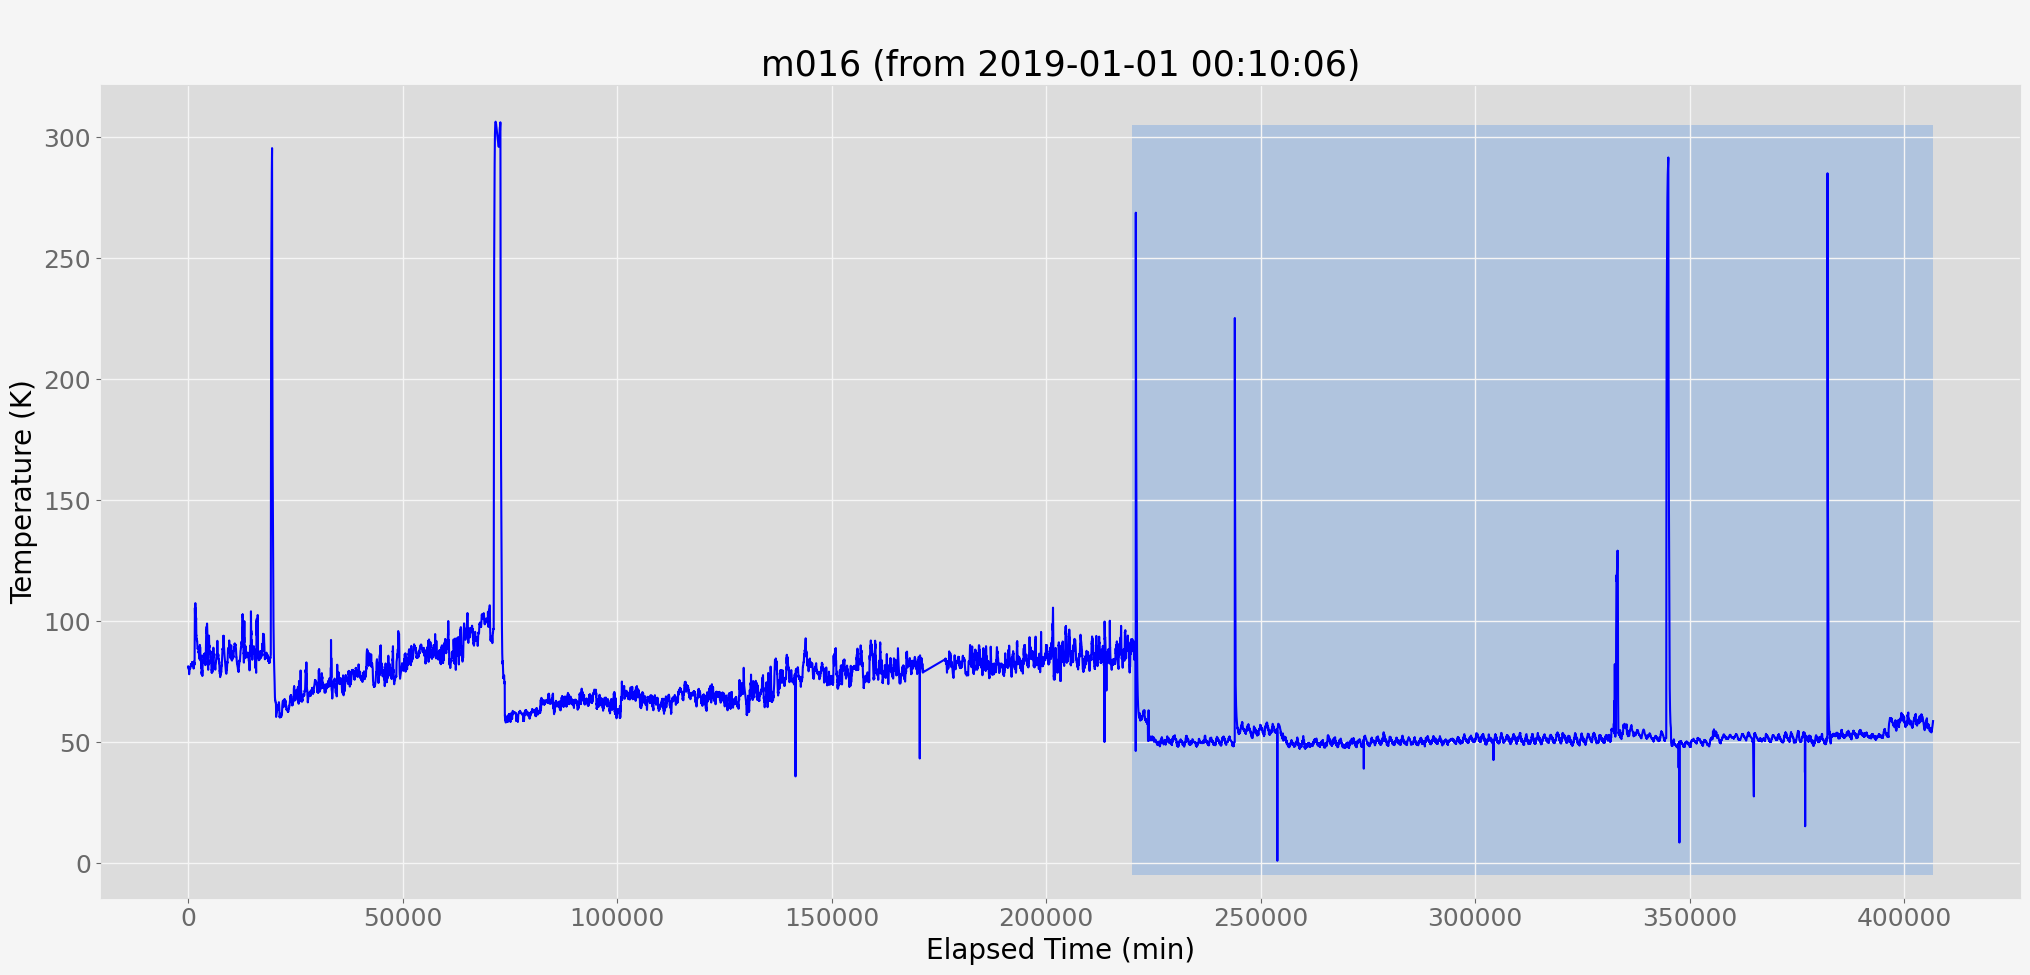

In [190]:
#Investigating and selection data range for REFERENCE
sensorLocation = TemperatureDataFiles.m016.name     #the sensor data being used
rfDt_strtTm_elpsd = 220000; rfDt_endTm_elpsd = None   #start and end elapsed times for the reference data set

fg,ax = tempPlot_all.plotData(atSensorLoc=sensorLocation)
rf_Dt = tempPlot_all.get_data_for_elapsedTime_range(startTime=rfDt_strtTm_elpsd, endTime=rfDt_endTm_elpsd, atSensorLoc=sensorLocation)
rfDt_strtTm_elpsd = float(rf_Dt.Elapsed_Time[0]); rfDt_endTm_elpsd = float(rf_Dt.Elapsed_Time[-1])
hilite_plots( #hilighting the section of the data for reference
    on_ax=ax, 
    for_data=rf_Dt, 
    from_time_elapsed=rfDt_strtTm_elpsd, 
    to_time_elapsed=rfDt_endTm_elpsd,
    time_delta=tempPlot_all.get_time_delta(atSensorLoc = sensorLocation),
    min_y=0,  max_y=300
)
fg.set_size_inches(20, 10)
#_ = adjustPlotView(ax=ax, xMin=rfDt_strtTm_elpsd, xMax=rfDt_endTm_elpsd, yMin=None, yMax=None)
#_ = adjustPlotView(ax=ax, xMin=250000, xMax=300000, yMin=30, yMax=80)

#### Preparing Data for Training

In [191]:
#dt_for_detection = tempPlot_all.get_data(atSensorLoc=sensorLocation)
dt_for_detection = tempPlot_all.get_data_for_elapsedTime_range(startTime=150000, endTime=None, atSensorLoc=sensorLocation)

outlr_detection = OutlierDetection(
    data_for_detection = dt_for_detection, 
    ref_data_start_elapsed_time = rfDt_strtTm_elpsd, 
    ref_data_end_elapsed_time = rfDt_endTm_elpsd 
)
start_time_elapsed = float(outlr_detection.get_original_data().Elapsed_Time[0]); end_time_elapsed = float(outlr_detection.get_original_data().Elapsed_Time[-1])


LOCATING OUTLIERS IN Reference dataset... waiting for last iteration
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Ite

In [85]:
#outlr_detection.get_original_data()

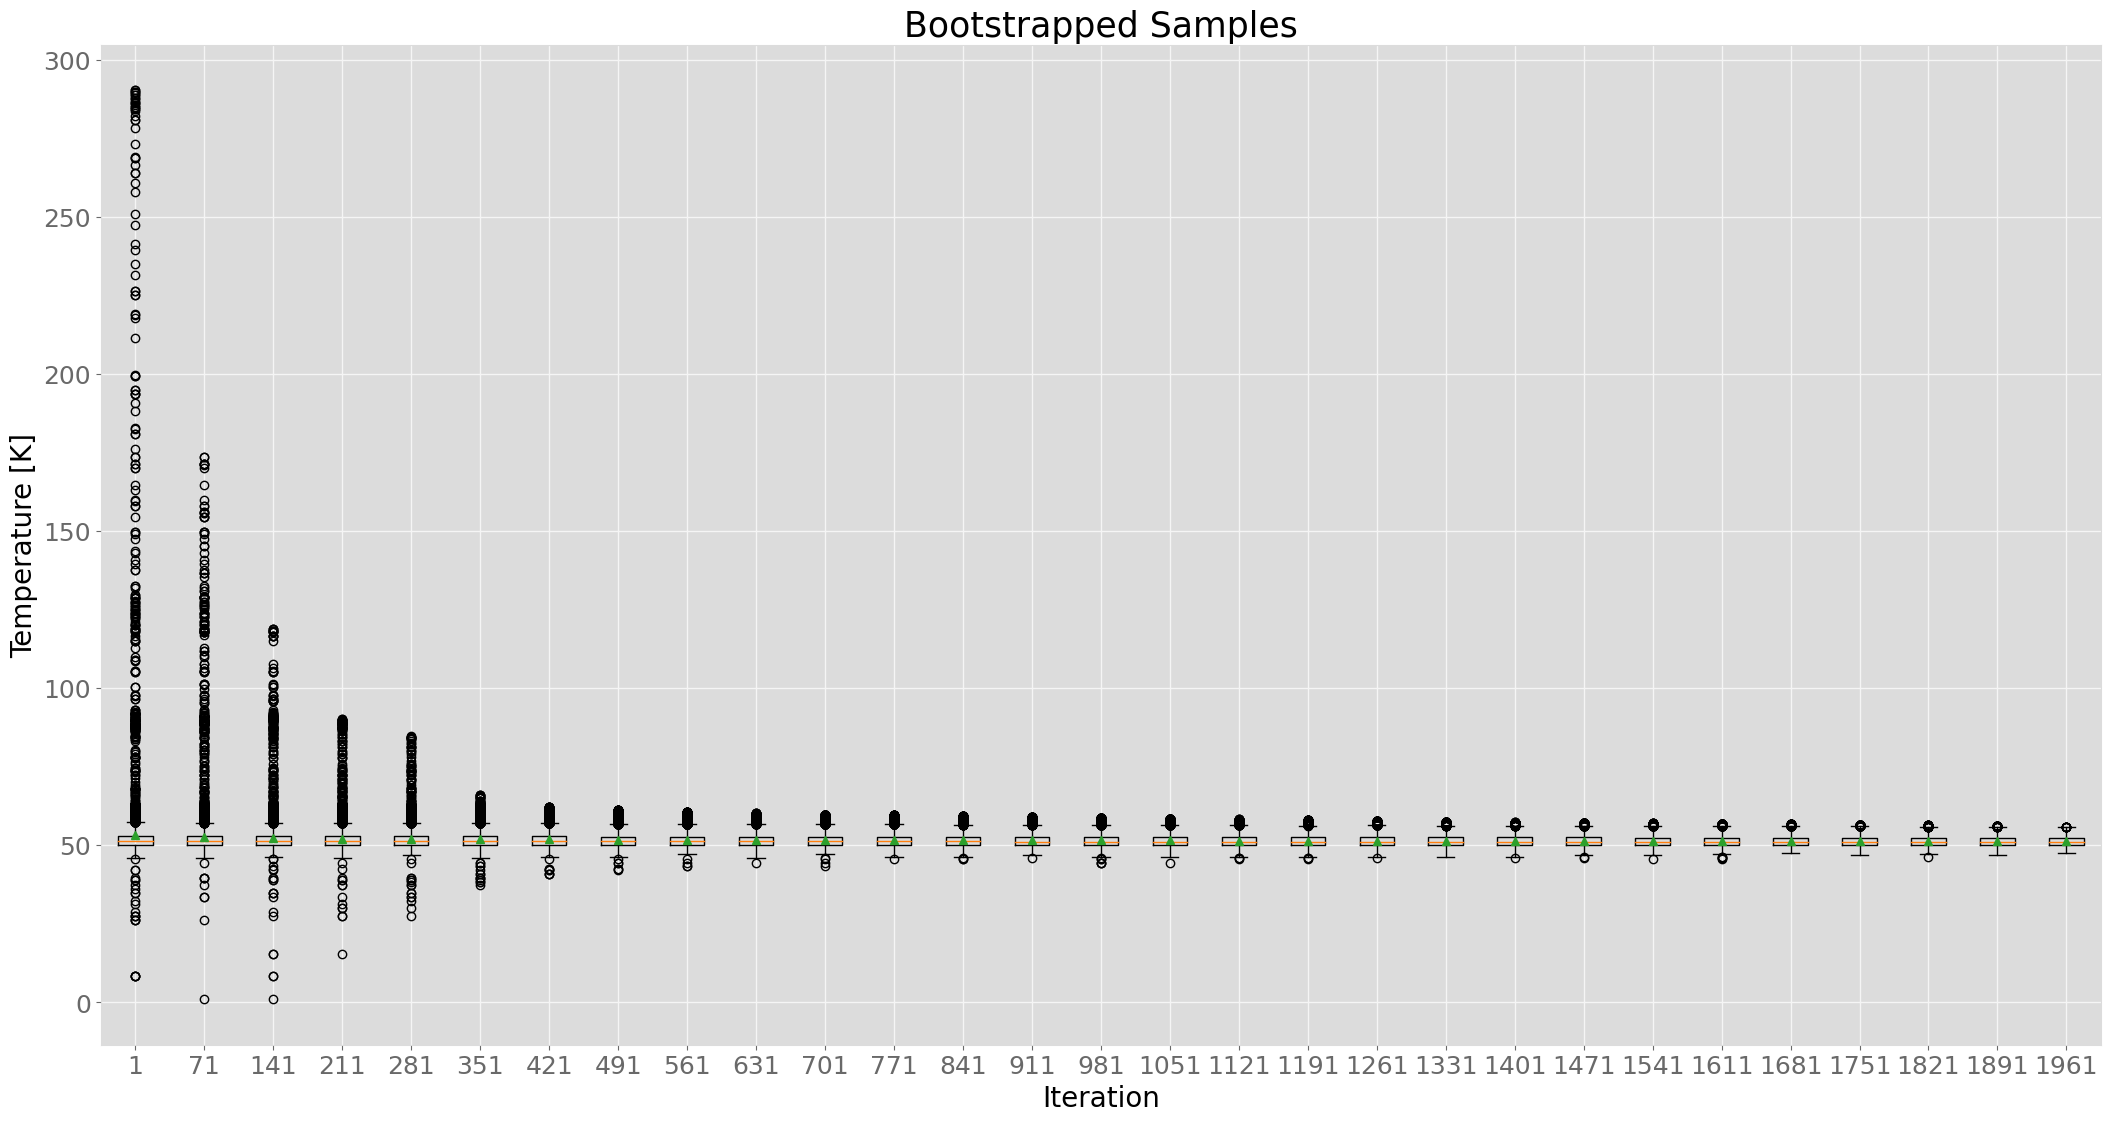

In [192]:
#Boxplot of the Bootstrap of Reference Data Set
fg,ax = outlr_detection.plot_boxplots(
    start_ndx = 0, 
    end_ndx = -1, 
    step_sz = 70
)
fg.set_size_inches(20,10)

In [194]:
mDt = outlr_detection.get_original_data() 
rfDt = outlr_detection.get_reference_data()

In [195]:
mDt

,timestamp,Value,Elapsed_Time,is_outlier
Date_Time,,,,
2019-04-15 04:10:06,1555301406,75.81843,150000.0,1
2019-04-15 04:20:06,1555302006,75.85366,150010.0,1
2019-04-15 04:30:06,1555302606,76.65932,150020.0,1
2019-04-15 04:40:06,1555303206,76.33799,150030.0,1
2019-04-15 04:50:06,1555303806,75.61180,150040.0,1
...,...,...,...,...
2019-10-10 10:10:06,1570702206,58.01558,406680.0,0
2019-10-10 10:20:06,1570702806,58.20484,406690.0,0
2019-10-10 10:30:06,1570703406,58.33609,406700.0,0


##### Exploring the Reference Data

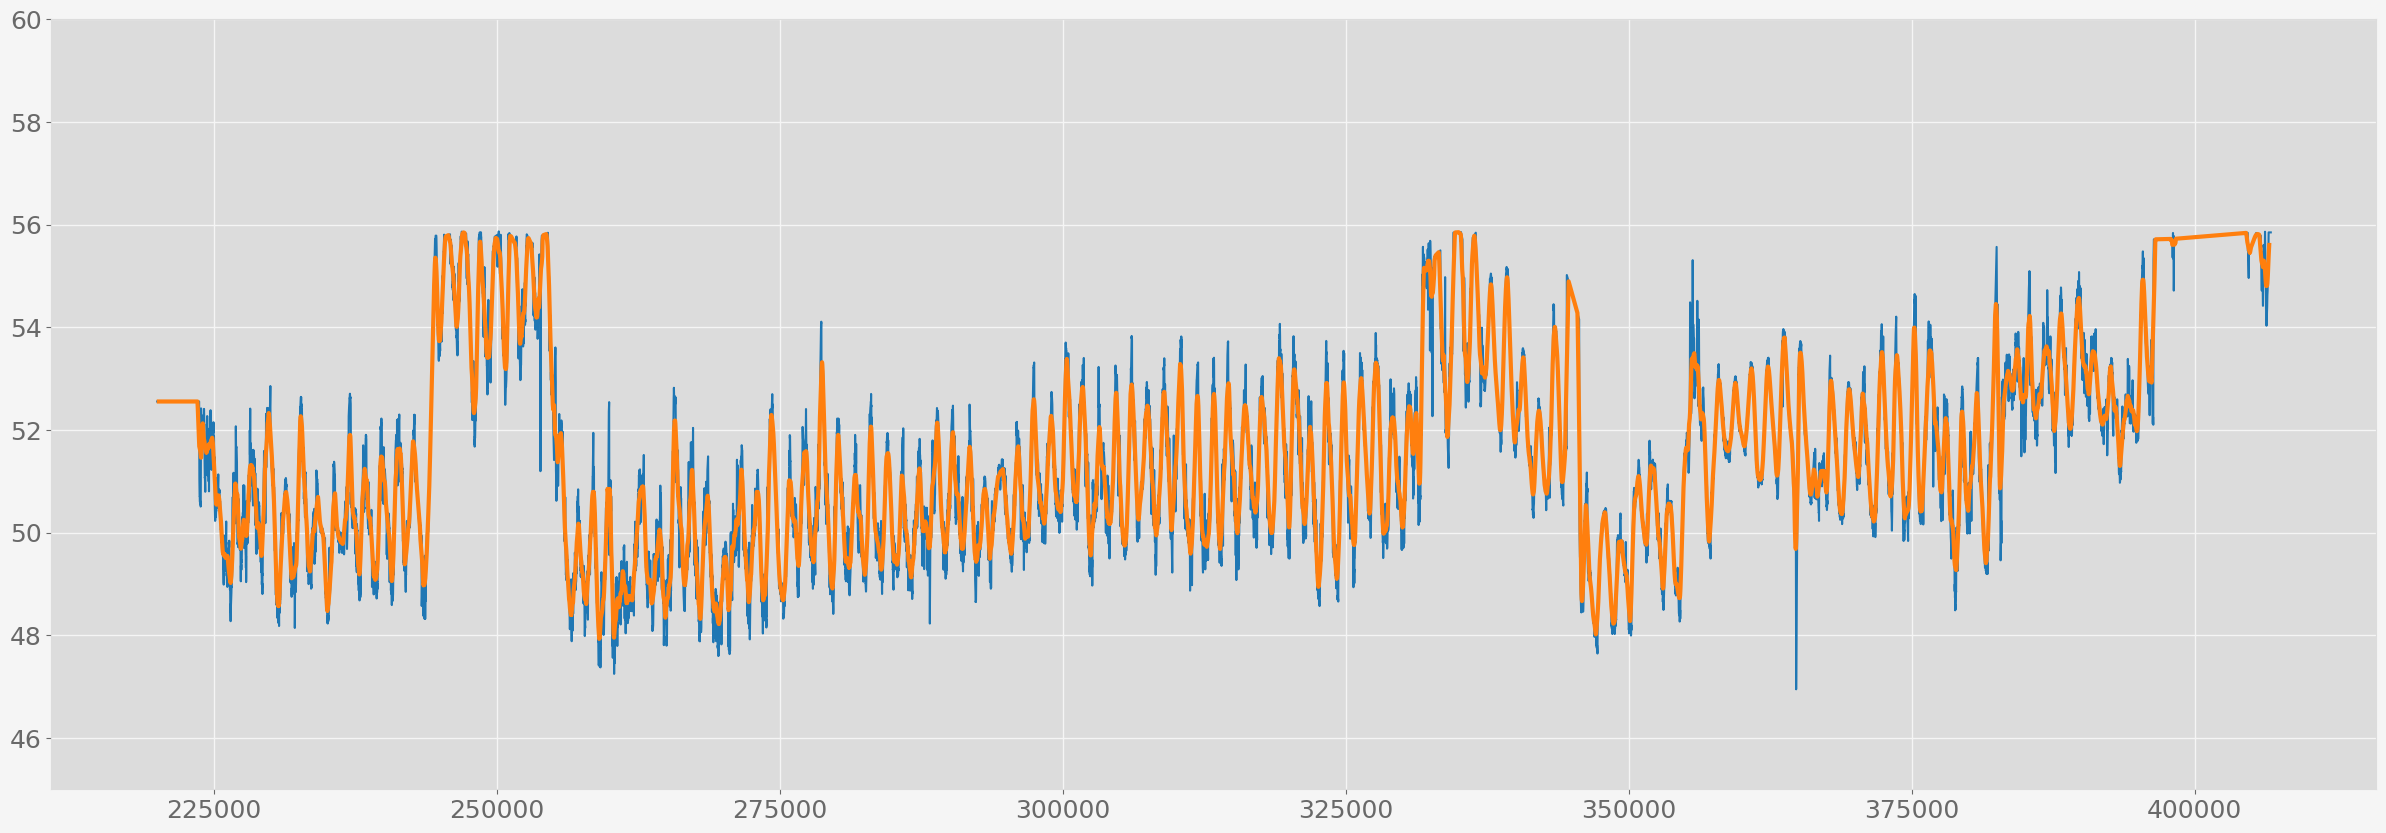

In [200]:
#Determining the best rolling window to smoothen data for the determining the period of the acf, and therefore, the appropriate window size for the periodic data
rlng_win = 31 
rlng_win_mavg = rfDt.Value.rolling(rlng_win, center=True, closed='both').mean() 
fg,ax = get_plot_fig_ax()
_ = ax.plot(rfDt.Elapsed_Time, rfDt.Value, label='Reference Data')
_ = ax.plot(rfDt.Elapsed_Time, rlng_win_mavg, color='tab:orange', linewidth=3, label=f'Rolling Mean (window={rlng_win})')
_ = adjustPlotView(
    ax=ax, 
    xMin=None,  
    xMax=None,  
    yMin=45, yMax=60
)

The period is: 1440.0, and nlags is: 18644


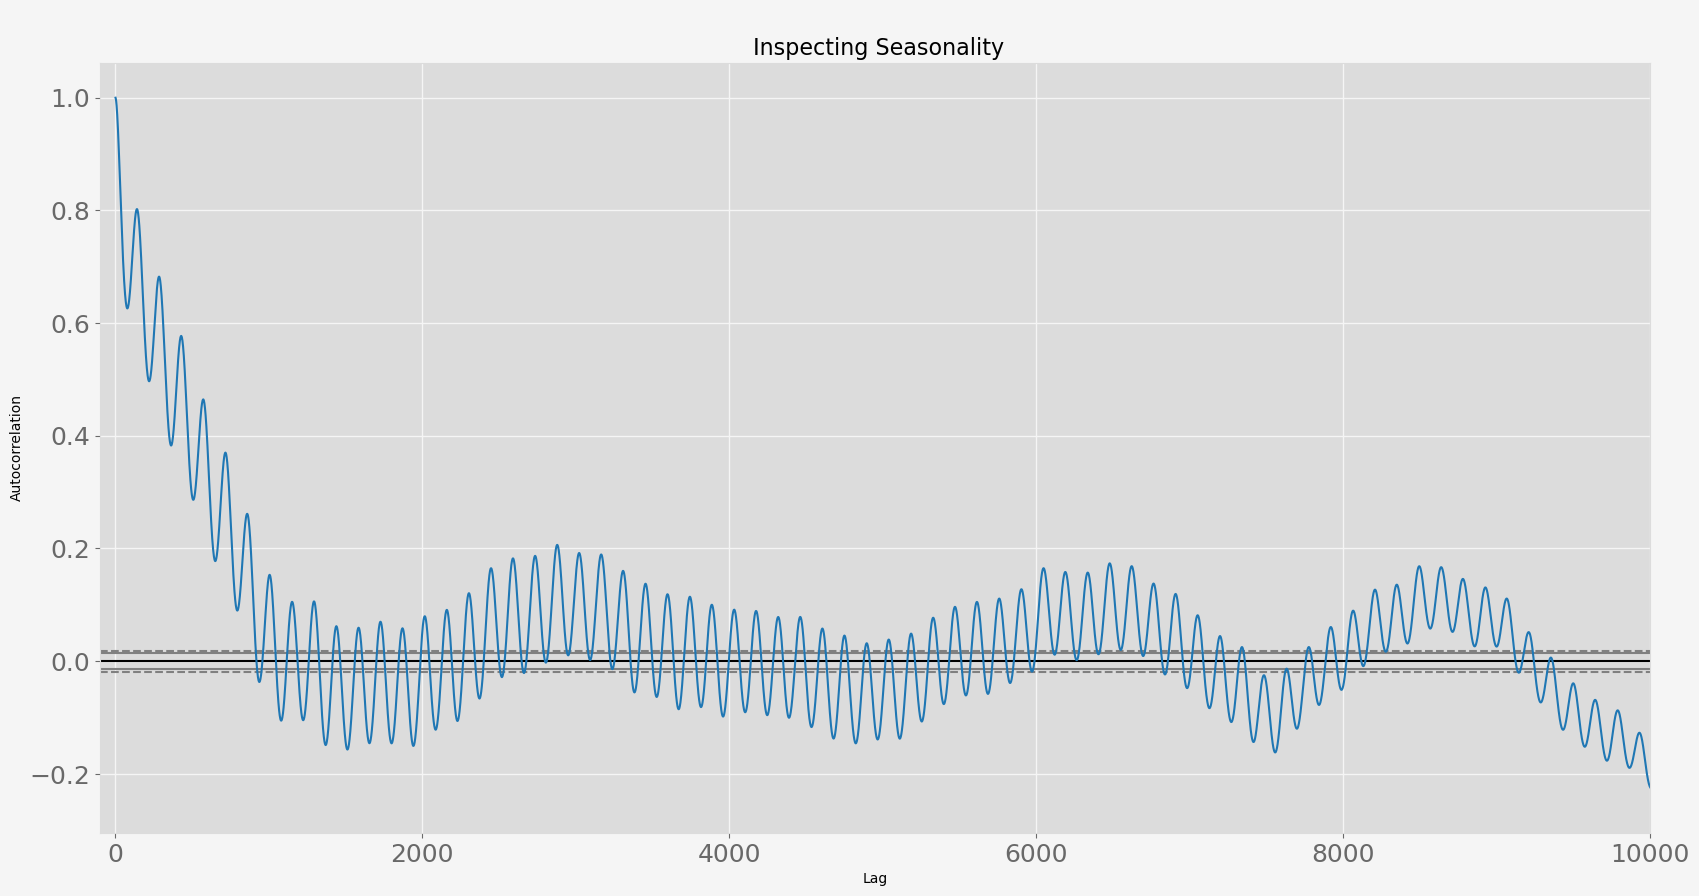

In [199]:
#Plot of the acf used to determing the ideal window size used in the modeling data
tm_delta = outlr_detection.get_time_delta()
data_for_period = rfDt 
data_for_period_mavg = data_for_period.Value.rolling(rlng_win, center=True, closed='both').mean().tolist()
data_for_period_mavg = [x for x in data_for_period_mavg if math.isnan(x) == False]
acf_fg,acf_ax = get_plot_fig_ax()
_ = autocorrelation_plot(series=data_for_period_mavg, ax=acf_ax); format_axis(ax=acf_ax)
acf_ax.set_title('\n Inspecting Seasonality', fontsize=16)
_ = adjustPlotView(ax=acf_ax, xMin=-100, xMax=10000, yMin=None, yMax=None)

#Determining the ideal window size for the modeling data
nlg = len(data_for_period_mavg)
acf_of_data_for_period = acf(data_for_period_mavg, nlags=nlg)
wn_sz = period_of_acf(acf_vals=acf_of_data_for_period)*tm_delta
print(f"The period is: {wn_sz}, and nlags is: {nlg}")
acf_fg.set_size_inches(20,10)

In [205]:
outlr_detection.create_windowed_data(with_window_size=wn_sz) #120


CREATING windowed data...
Windowed data created

COUNTING OUTLIERS IN WINDOWED DATA...
Finished counting outliers in windowed data...


In [92]:
outlr_detection.get_time_window_size()

1440

In [206]:
thold_factor = 0.75
outlr_detection.adjust_threshold_factor(factor=thold_factor)


LOCATING OUTLIERS IN DATASET...
Finished locating outliers in dataset


In [207]:
outlr_detection.get_thresholds()

[40.25747750000001, 62.558052499999995]

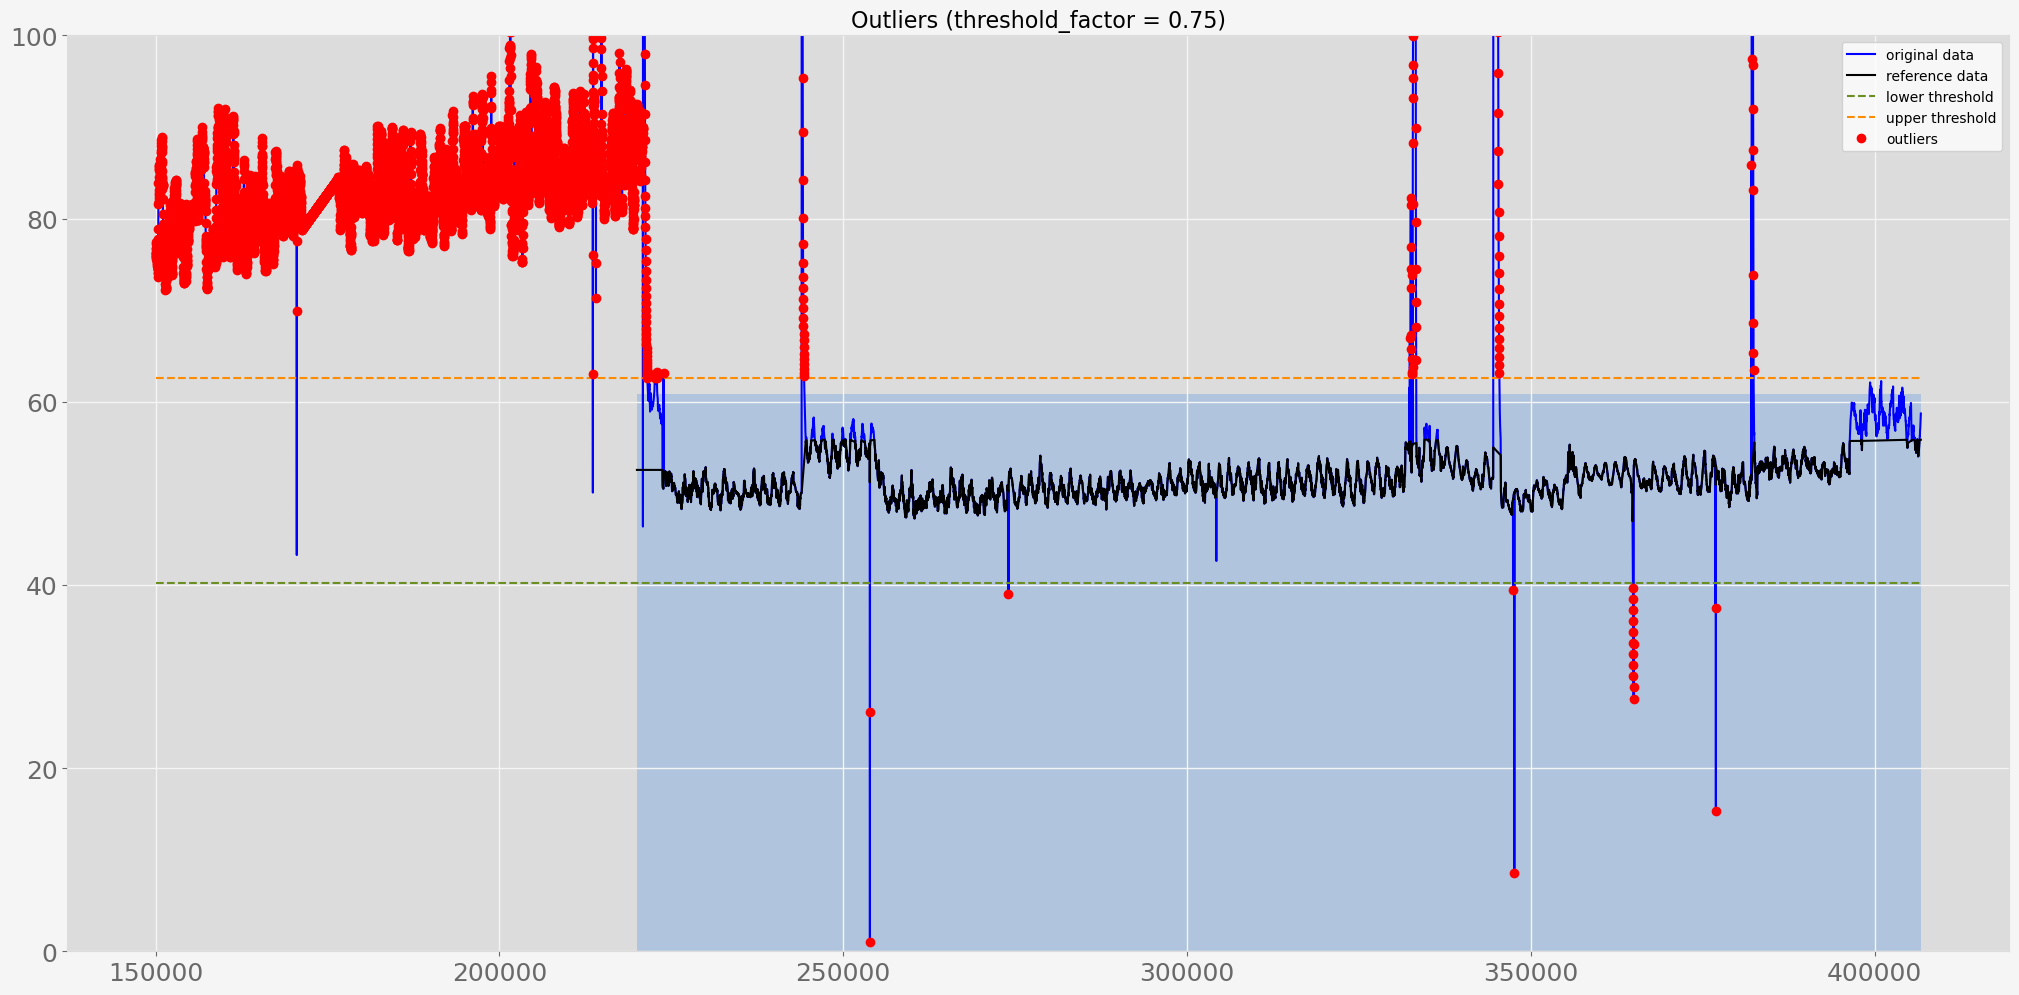

In [209]:
#Inspecting the Reference Data
fg,ax = get_plot_fig_ax()
_ = ax.plot(mDt.Elapsed_Time, mDt.Value, color='b', label='original data')

hilite_plots(
    on_ax=ax, 
    for_data=rfDt, 
    from_time_elapsed=rfDt_strtTm_elpsd, 
    to_time_elapsed=rfDt_endTm_elpsd,
    time_delta = outlr_detection.get_time_delta(),
    min_y=0,    max_y=None
)

_ = ax.plot(rfDt.Elapsed_Time, rfDt.Value, color='k', label='reference data')

outlr_detection.plot_thresholds(on_axis=ax, lower_threshold_color='olivedrab', upper_threshold_color='darkorange')
outlr_detection.plot_outliers(plot_fg=fg, plot_ax=ax)
_ = ax.legend()
_ = adjustPlotView(
    ax=ax, 
    xMin=start_time_elapsed, 
    xMax=None,  #end_time_elapsed, 
    yMin=0, yMax=100)
#_ = adjustPlotView(ax=ax, xMin=375000, xMax=380000, yMin=40, yMax=60)
ax.set_title(f'Outliers (threshold_factor = {thold_factor})', fontsize=16)
fg.set_size_inches(20,10)

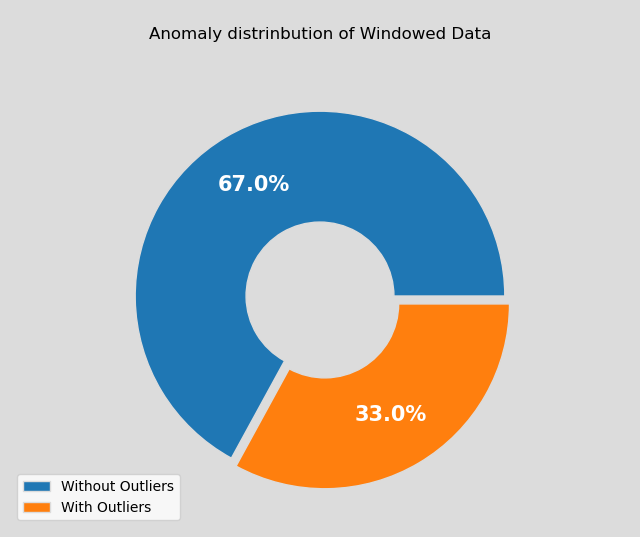

In [212]:
fg,ax = outlr_detection.plot_class_distribution()
_ = ax.set_title(f"\nAnomaly distrinbution of Windowed Data\n")

In [213]:
tempPlot_all.get_closest_dateTime(toTimeElapsed_in_minutes=400000, atSensorLoc=sensorLocation)

Timestamp('2019-10-05 18:50:06')

________________________________________________________________________________________________________________________________________

##### Locating Outliers within windows of a Given Size

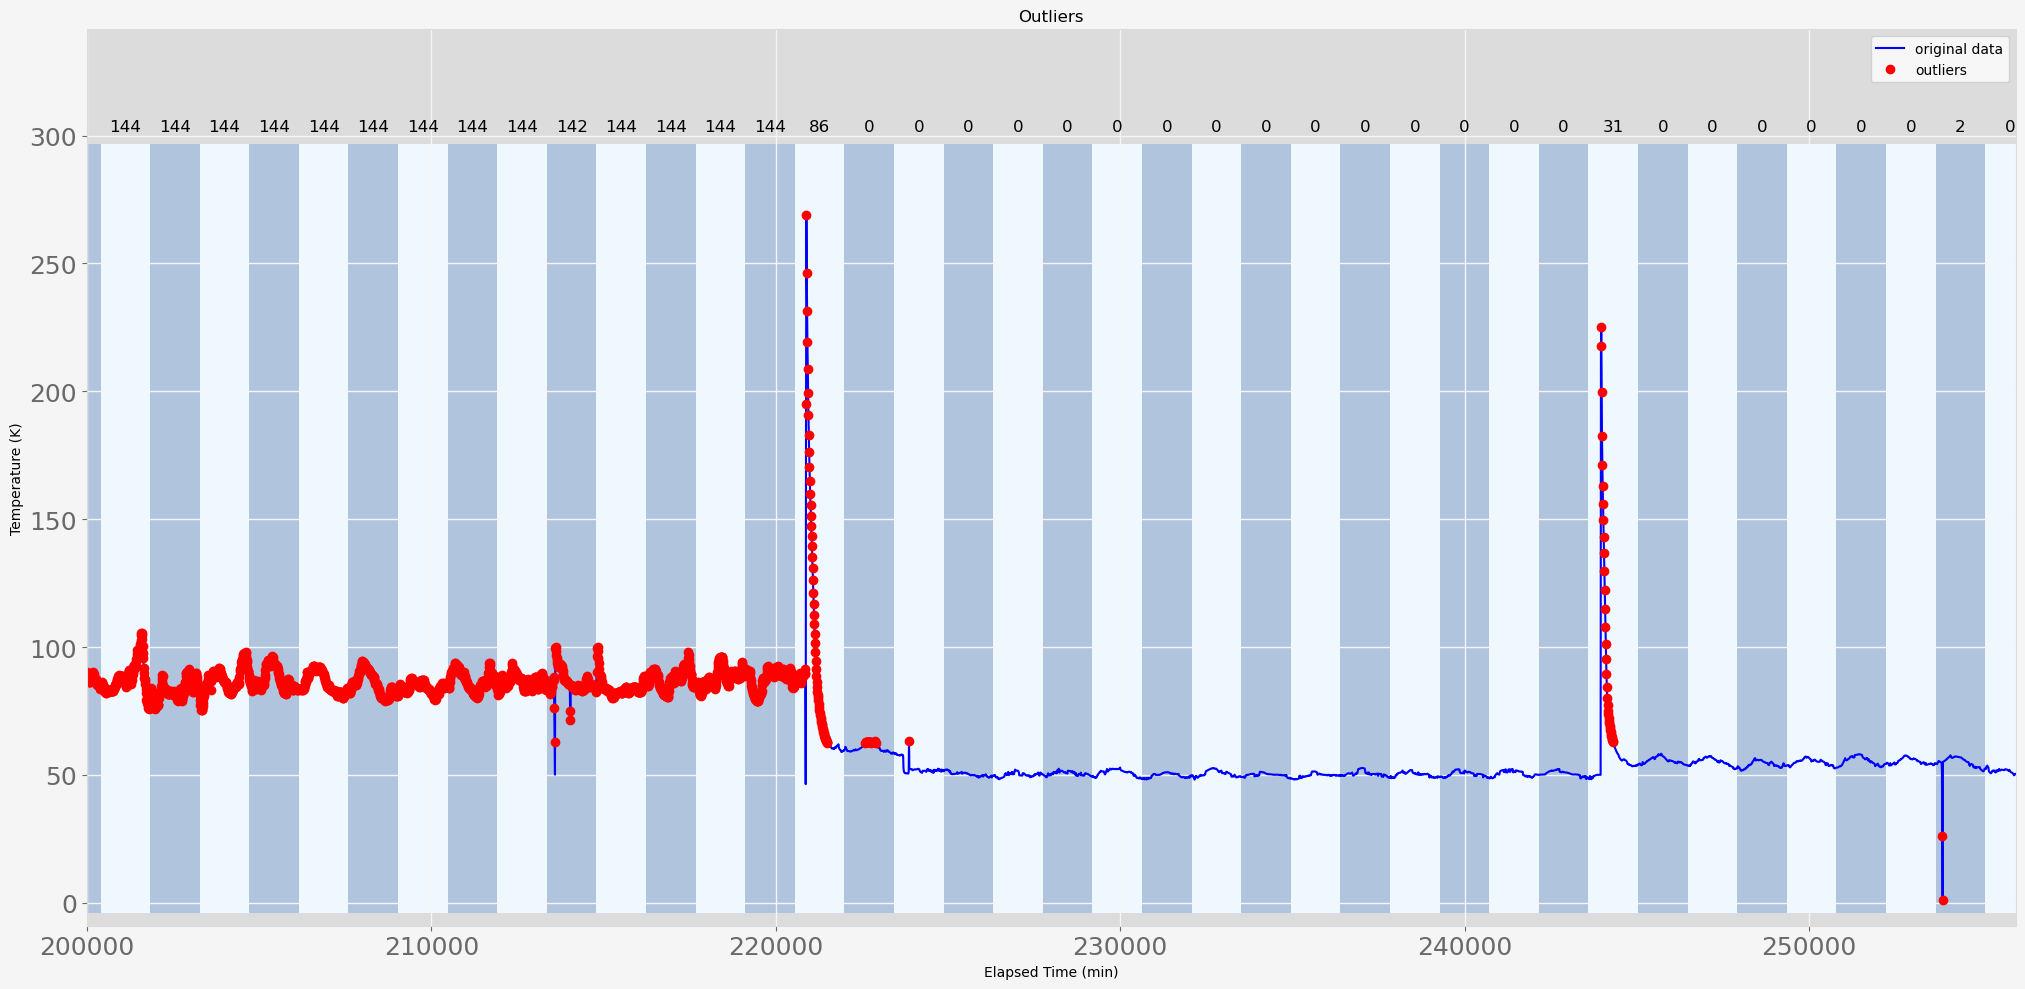

In [216]:
from_elpsdTm = int(outlr_detection.get_original_data().Elapsed_Time[0])  
to_elpsdTm = int(outlr_detection.get_original_data().Elapsed_Time[-1]) 
from_Tm = tempPlot_all.get_closest_dateTime(toTimeElapsed_in_minutes=from_elpsdTm, atSensorLoc=sensorLocation)
to_Tm = tempPlot_all.get_closest_dateTime(toTimeElapsed_in_minutes=to_elpsdTm, atSensorLoc=sensorLocation)
start_date_time = from_Tm.strftime("%Y-%m-%d, %H:%M:%S")   
end_date_time = to_Tm.strftime("%Y-%m-%d, %H:%M:%S")

fg,ax = outlr_detection.show_windowed_data(
    from_date_time = start_date_time,
    to_date_time = end_date_time,
    #on_ax=ax, with_fg=fg,
    show_outliers = True,
    show_counts = True,
    #adjust_plot_to = {'xMin': 200000,'xMax': 256000,'yMin': 40,'yMax': 100}
    adjust_plot_to = {'xMin': 200000,'xMax': 256000,'yMin': None,'yMax': None}
)
fg.set_size_inches(20, 10)

##### Locating Anomalies in a Specific Window

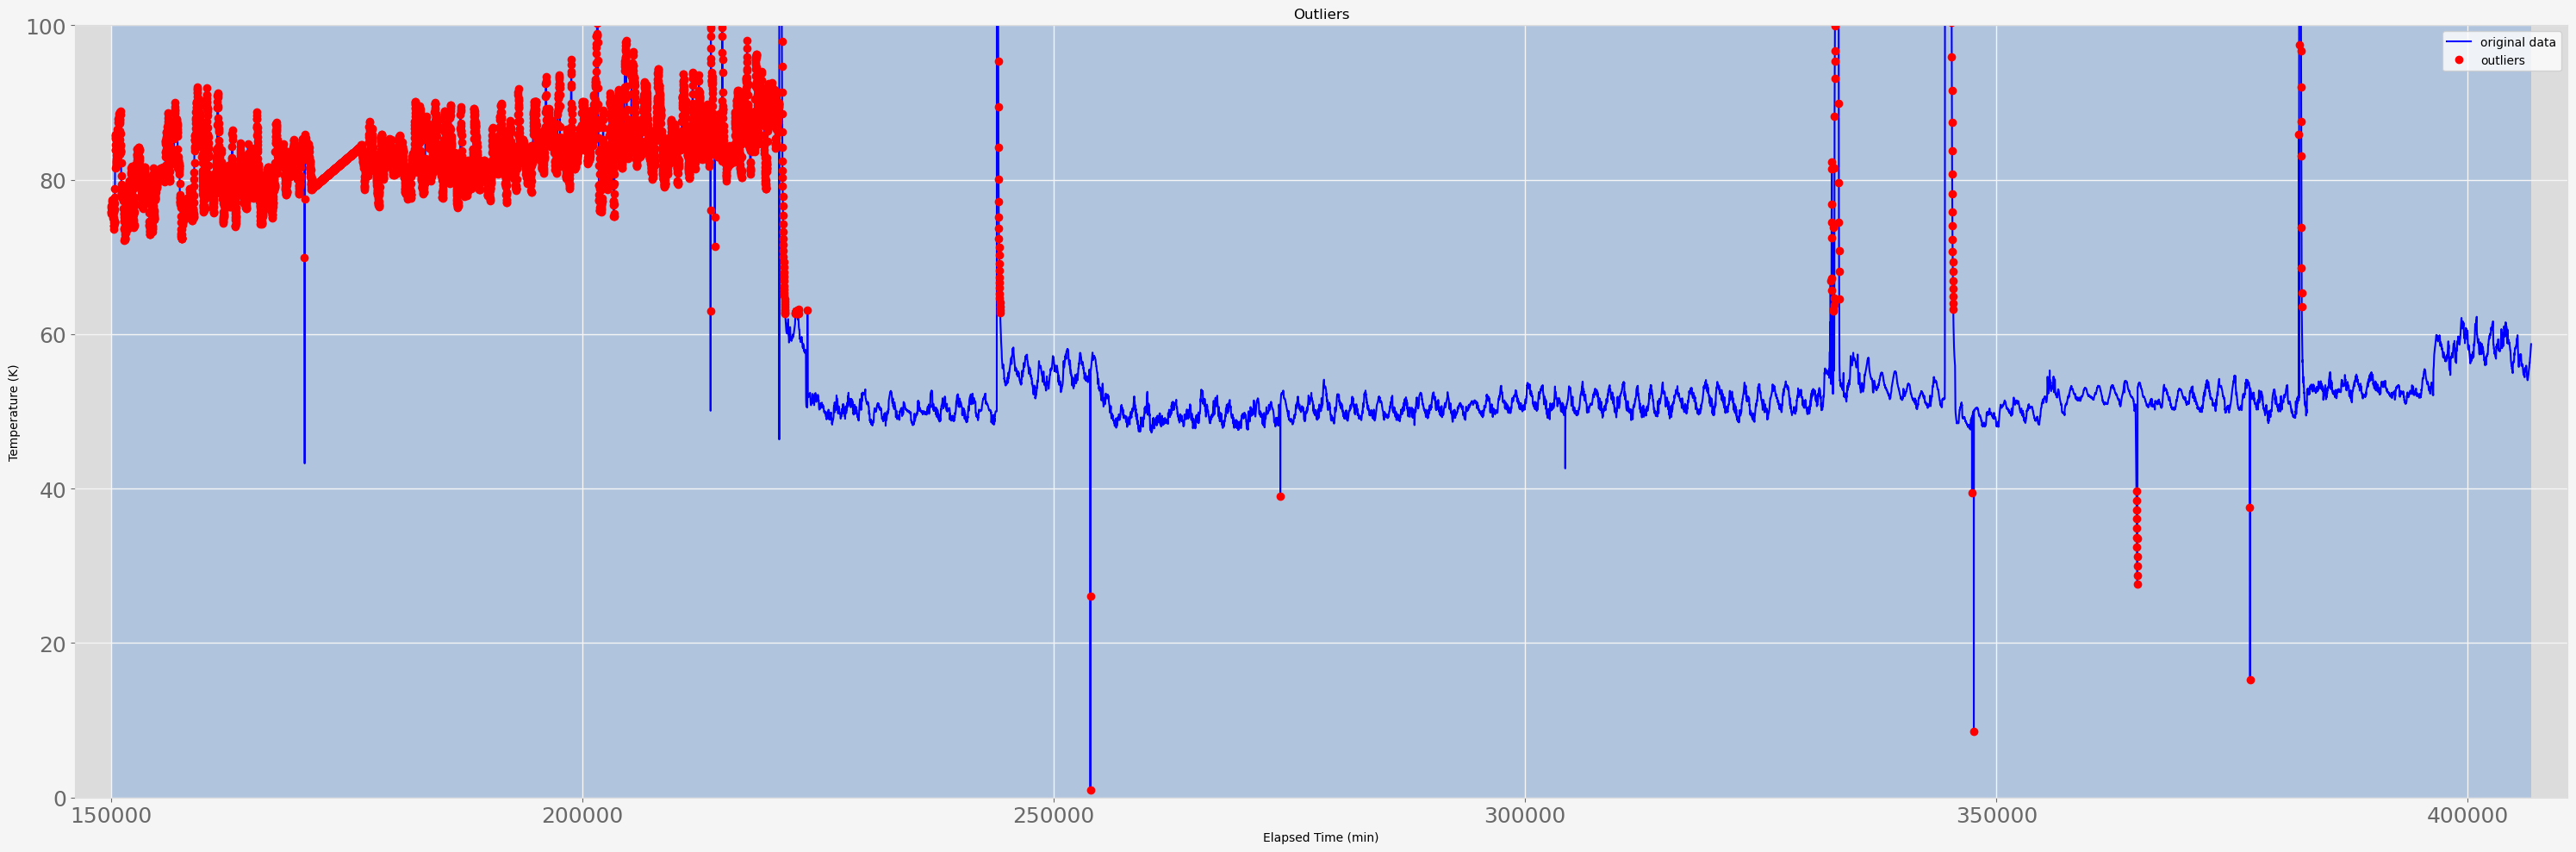

In [217]:
fg,ax,num_of_outlrs = outlr_detection.show_plots_in_window(
    from_date_time = start_date_time,
    to_date_time = end_date_time,
    #on_ax=ax, with_fg=fg,
    show_outliers = True,
    show_counts = True,
    adjust_plot_to = {'xMin': None,'xMax': None,'yMin': 0,'yMax': 100}
)

In [218]:
windowed_data_with_features = outlr_detection.create_data_features()

/var/folders/bh/f3v3m3z90zvcfdm02y_bdkg40000gn/T/ipykernel_16482/2770431344.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windowed_data_features[col_hdr] = colVals
/var/folders/bh/f3v3m3z90zvcfdm02y_bdkg40000gn/T/ipykernel_16482/2770431344.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windowed_data_features[col_hdr] = colVals
/var/folders/bh/f3v3m3z90zvcfdm02y_bdkg40000gn/T/ipykernel_16482/2770431344.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [219]:
windowed_data_with_features

,window_start,num_of_outliers,has_outliers,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_135,x_136,x_137,x_138,x_139,x_140,x_141,x_142,x_143,x_144
Date_Time,,,,,,,,,,,,,,,,,,,,,
2019-04-15 04:10:06,150000,144,1,75.81843,75.85366,76.65932,76.33799,75.61180,76.26035,77.39873,...,74.73179,74.57074,75.58369,75.77265,75.12082,73.66030,73.59118,72.15708,72.88512,73.93360
2019-04-16 04:10:06,151440,144,1,72.51252,72.52084,73.26973,72.26959,73.82427,72.27253,72.40649,...,83.95613,83.60659,83.22361,82.78591,82.67113,82.53571,82.10282,82.08772,82.21839,82.67329
2019-04-17 04:10:06,152880,144,1,82.98269,83.12561,83.06364,83.52597,83.88166,84.15889,84.19740,...,74.55716,74.68698,74.71122,74.75019,75.51644,76.20457,76.55259,76.27999,76.13479,76.09736
2019-04-18 04:10:06,154320,144,1,75.94394,75.61372,74.59044,74.09460,73.75382,73.56188,73.22694,...,80.94227,80.56477,79.95640,79.75920,80.27978,80.78140,81.19792,81.83182,82.91366,83.57049
2019-04-19 04:10:06,155760,144,1,83.63862,84.69512,84.96443,85.03291,84.90644,85.01899,84.50247,...,81.99162,82.40519,82.11599,82.68497,82.21336,82.04422,82.99126,82.44047,81.61910,81.36945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-05 04:10:06,399120,0,0,58.66563,58.63804,58.74273,58.83255,58.95859,59.20025,59.33691,...,57.10910,57.04542,56.90987,56.90577,56.96552,57.00731,56.88472,57.14660,57.66770,57.71760
2019-10-06 04:10:06,400560,0,0,57.59740,57.53738,57.33118,57.25072,57.09222,57.04987,57.02252,...,57.01550,57.01351,56.84752,56.64932,56.31558,56.05164,56.64922,56.93859,57.02450,57.09113
2019-10-07 04:10:06,402000,0,0,57.06320,57.11137,57.17513,57.21247,57.16505,57.26520,57.44382,...,58.04603,58.05173,58.03075,58.04694,57.98322,57.87338,57.76273,57.81495,58.01699,57.93976


In [220]:
ftr_hdngs = windowed_data_with_features.drop(columns=['window_start','num_of_outliers','has_outliers']).columns
print(ftr_hdngs.tolist())

['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'x_65', 'x_66', 'x_67', 'x_68', 'x_69', 'x_70', 'x_71', 'x_72', 'x_73', 'x_74', 'x_75', 'x_76', 'x_77', 'x_78', 'x_79', 'x_80', 'x_81', 'x_82', 'x_83', 'x_84', 'x_85', 'x_86', 'x_87', 'x_88', 'x_89', 'x_90', 'x_91', 'x_92', 'x_93', 'x_94', 'x_95', 'x_96', 'x_97', 'x_98', 'x_99', 'x_100', 'x_101', 'x_102', 'x_103', 'x_104', 'x_105', 'x_106', 'x_107', 'x_108', 'x_109', 'x_110', 'x_111', 'x_112', 'x_113', 'x_114', 'x_115', 'x_116', 'x_117', 'x_118', 'x_119', 'x_120', 'x_121', 'x_122', 'x_123', 

In [221]:
outlr_detection.get_input_output_vals()

(array([[75.81843, 75.85366, 76.65932, ..., 72.15708, 72.88512, 73.9336 ],
        [72.51252, 72.52084, 73.26973, ..., 82.08772, 82.21839, 82.67329],
        [82.98269, 83.12561, 83.06364, ..., 76.27999, 76.13479, 76.09736],
        ...,
        [57.0632 , 57.11137, 57.17513, ..., 57.81495, 58.01699, 57.93976],
        [57.92954, 58.04514, 58.12301, ..., 56.36511, 56.42319, 56.50417],
        [56.4461 , 56.3602 , 56.40762, ..., 54.43805, 54.37202, 54.28724]]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

________________________________________________________________________________________________________________________________________

### Building the Anomaly Detection Models

In [222]:
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [225]:
class ClassificationModels(Enum):  
    logisticRegression = {
        'name':'Logistic Regression',
        'model':LogisticRegression(solver='liblinear', C=0.05, multi_class='ovr', random_state=0)
    }
    supportVectorMachine = {  #"Support Vector Classifier"
        'name':'Linear SVM',
        'model':SVC(kernel='linear', probability=True)
    }
    randomForest = {
        'name':'Random Forest',
        'model':RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    }

    neuralNetwork = {
        'name':'Neural Network',
        'model':MLPClassifier(alpha=1, max_iter=1000)
    }
    


class DataModeling:
    def __init__(self, input_output_values=[], feature_1=1, feature_2=2):
        self.__X_train_original = np.array([])
        self.__y_train_original = np.array([])
        self.__X_train = np.array([])
        self.__y_train = np.array([])
        self.__X_test = np.array([])
        self.__y_test = np.array([])
        self.__ftrs = [min([feature_1,feature_2]), max([feature_1,feature_2])]
        self.__fitted_models = {}
        self.__scaler = StandardScaler()
        self.__completeInit(mdata=input_output_values)


    def __completeInit(self, mdata):
        if self.__ftrs[0] == self.__ftrs[1]:
            print(Fore.RED+"\nError! "+Fore.GREEN+"You have the same feature of the dataset for the training. You should select two different features.\n") #Error Message
        else:
            #Split the data into train and test sets
            self.__X_train_original,self.__X_test,self.__y_train_original,self.__y_test = train_test_split(mdata[0], mdata[1], train_size=0.8, stratify=y, random_state=0)  #100
            self.__resample_data(mdata=mdata)
        

    def __extract_categories(self, mdata=[]):   #mdata=[X, y] 
        x_0s = []; x_1s = []        
        for j in range(len(mdata[1])):
            test_for_outlr = mdata[1][j]
            if test_for_outlr==1:
                x_1s.append(mdata[0][j])
            else:
                x_0s.append(mdata[0][j])
        return np.array(x_0s), np.array(x_1s)  
    

    #Oversampling the train data using SMOTE
    def __resample_data(self, mdata=[]):   #mdata=[xTrain, yTrain] data        
        counter = Counter(mdata[1])
        print(f'Class Distribution (before oversampling): {counter}')
        oversample = SMOTE()
        self.__X_train, self.__y_train = oversample.fit_resample(mdata[0], mdata[1])
        counter = Counter(self.__y_train)
        print(f'Class Distribution (AFTER oversampling): {counter}')        


    def plot_class_distribution(self):
        ftr_1 = self.__ftrs[0]; ftr_2 = self.__ftrs[1]
        fg = plt.figure(figsize=(15,10))
        fg.set_facecolor(PlotProperties.figFaceColor.value)
        fg.suptitle('\n\nMy Plots\n\n')

        subfgs = fg.subfigures(1, 2, wspace=0.7)
        subfgs[0].set_facecolor(PlotProperties.figFaceColor.value)
        subfgs[0].suptitle("Before Oversampling")
        subfgs[1].set_facecolor(PlotProperties.axisFaceColor.value)
        subfgs[1].suptitle("After Oversampling")

        bfr_sm_axs = subfgs[0].subplots(2,1)
        format_axis(bfr_sm_axs[0])
        format_axis(bfr_sm_axs[1])
        bfr_sm_axs[0].set_facecolor(PlotProperties.figFaceColor.value)
        bfr_sm_axs[1].set_facecolor('lavender')
        bfr_sm_axs[0].grid(False)
        bfr_sm_axs[1].grid(False)
        for spine in bfr_sm_axs[1].spines.values():
            spine.set_edgecolor('lavender')

        aft_sm_axs = subfgs[1].subplots(2,1)
        format_axis(aft_sm_axs[0])
        format_axis(aft_sm_axs[1])
        aft_sm_axs[0].set_facecolor(PlotProperties.axisFaceColor.value)
        aft_sm_axs[1].set_facecolor('lavender')
        aft_sm_axs[0].grid(False)
        aft_sm_axs[1].grid(False)
        for spine in aft_sm_axs[1].spines.values():
            spine.set_edgecolor('lavender')

        X_train_original_0s, X_train_original_1s = self.__extract_categories(mdata=[self.__X_train_original, self.__y_train_original])
        X_train_0s, X_train_1s = self.__extract_categories(mdata=[self.__X_train, self.__y_train])

        myLbls = ['Without Outliers', 'With Outliers']
        bfr_sm_axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        bfr_sm_axs[0].pie(
            [len(X_train_original_0s), len(X_train_original_1s)], 
            autopct='%1.1f%%', pctdistance=0.725,
            labels=myLbls, labeldistance=None,
            explode=(0.0, 0.04),
            wedgeprops=dict(width=0.6, edgecolor=subfgs[0].get_facecolor(), linewidth=2),
            textprops=dict(color="w", font=dict(size=14, weight='semibold'))
        )
        _ = bfr_sm_axs[0].legend()

        aft_sm_axs[0].axis('equal')
        aft_sm_axs[0].pie(
            [len(X_train_0s), len(X_train_1s)], 
            autopct='%1.1f%%', pctdistance=0.7,
            labels=myLbls, labeldistance=None,
            wedgeprops=dict(width=0.6, edgecolor=subfgs[1].get_facecolor(), linewidth=0),
            textprops=dict(color="w", font=dict(size=14, weight='semibold'))
        )
        _ = aft_sm_axs[0].legend()

        bfr_sm_axs[1].scatter([X_train_original_0s[x][ftr_1-1] for x in range(len(X_train_original_0s))], [X_train_original_0s[x][ftr_2-1] for x in range(len(X_train_original_0s))], label='in window WITHOUT outlier')
        bfr_sm_axs[1].scatter([X_train_original_1s[x][ftr_1-1] for x in range(len(X_train_original_1s))], [X_train_original_1s[x][ftr_2-1] for x in range(len(X_train_original_1s))], label='in window with outlier')
        #bfr_sm_axs[1].set_title(f"Scatter plot for t{t_ndx_1} and t{t_ndx_2}")
        bfr_sm_axs[1].set_xlabel(f'x_{ftr_1}')
        bfr_sm_axs[1].set_ylabel(f'x_{ftr_2}')
        bfr_sm_axs[1].legend()

        aft_sm_axs[1].scatter([X_train_0s[x][ftr_1-1] for x in range(len(X_train_0s))], [X_train_0s[x][ftr_2-1] for x in range(len(X_train_0s))], label='in window WITHOUT outlier')
        aft_sm_axs[1].scatter([X_train_1s[x][ftr_1-1] for x in range(len(X_train_1s))], [X_train_1s[x][ftr_2-1] for x in range(len(X_train_1s))], label='in window with outlier')
        #aft_sm_axs[1].set_title(f"Scatter plot for t{t_ndx_1} and t{t_ndx_2}")
        aft_sm_axs[1].set_xlabel(f'x_{ftr_1}')
        aft_sm_axs[1].set_ylabel(f'x_{ftr_2}')
        _ = aft_sm_axs[1].legend()

    
    def train_models(self, models=[ClassificationModels]): 
        if (len(models) != 0):             
            # Scaling the input data
            X_train = self.__scaler.fit_transform(self.__X_train)            
            X_train = self.extract_features(X_data=X_train)
            y_train = self.__y_train  
            self.__fitted_models.clear()
            for mdl in models:
                self.__fitted_models[mdl.name] = (mdl.value["model"]).fit(X_train, y_train)
    
    def get_trained_models(self):
        return self.__fitted_models

    def extract_features(self, X_data, ftr1=None, ftr2=None):
        if ftr1 == None:
            ftr1 = self.__ftrs[0]
        if ftr2 == None:
            ftr2 = self.__ftrs[1]        

        ftr1_vals = X_data[:, ftr1-1]
        ftr2_vals = X_data[:, ftr2-1]
        return np.transpose(np.vstack([ftr1_vals,ftr2_vals]))

    def evaluate_model(self, model=ClassificationModels):
        try:
            ftd_mdl = self.__fitted_models[model.name] 
            X_train = self.__scaler.transform(self.__X_train)            
            X_train = self.extract_features(X_data=X_train)  
            X_test = self.__scaler.transform(self.__X_test)            
            X_test = self.extract_features(X_data=X_test) 
            y_train = self.__y_train
            y_test = self.__y_test
            
            #Obtaining Accuracy
            train_score = ftd_mdl.score(X_train, y_train)
            test_score = ftd_mdl.score(X_test, y_test)
            return train_score, test_score            
        except:
            print(Fore.RED+"\nError! "+Fore.GREEN+f"The model {model} has not yet been fitted with the train data. Fit the model with the train data before issuing this command.\n") #Error Message
            return None, None


    def make_prediction(self, X_data, with_model=ClassificationModels):
        ftd_mdl = self.__fitted_models[with_model.name]                
        X = self.__scaler.transform(X_data)
        X = self.extract_features(X_data=X)
        y_pred = ftd_mdl.predict(X)
        return y_pred


    def get_train_test_data(self): 
        train = [self.__X_train_original, self.__y_train_original]
        test = [self.__X_test, self.__y_test]
        return train, test


    def plot_decision_surface_boundary(self, model=ClassificationModels, ax=plt.axes, plot_surface=True, plot_boundary=False, plot_support_vectors=False):  #, data_to_scale=np.array([])):        
        ax.grid(False)
        cm = plt.cm.RdBu

        X_data = self.__scaler.transform(self.__X_train)     
        X_data = self.extract_features(X_data=X_data)
        xlim = [X_data[:,0].min(), X_data[:,0].max()] 
        ylim = [X_data[:,1].min(), X_data[:,1].max()] 
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ftd_mdl = self.__fitted_models[model.name]
        if plot_surface:
            DecisionBoundaryDisplay.from_estimator(
                estimator = ftd_mdl, 
                X = X_data, 
                cmap = cm, 
                alpha = 0.8, 
                ax = ax, 
                eps = 0.5
            )    

        if plot_boundary:
            DecisionBoundaryDisplay.from_estimator(
                estimator = ftd_mdl,
                X = X_data,
                plot_method="contour",
                colors="k",
                levels=[-1, 0, 1],
                alpha=0.8,
                linestyles=["--", "-", "--"],
                ax=ax,
            )    

        if plot_support_vectors and plot_boundary and model==ClassificationModels.supportVectorMachine:
            ax.scatter(
                ftd_mdl.support_vectors_[:, 0],
                ftd_mdl.support_vectors_[:, 1],
                s=80,
                linewidth=1,
                facecolors="none",
                edgecolors="k",
                zorder = 10
            )


    def plot_scaled_dataset(self, mdata=[np.array([])], ax=plt.axes, plt_size=50, plt_color="b", plt_label=None):    #mdata=[X_data,y_pred]                
        X = self.__scaler.transform(mdata[0])        
        X_0s, X_1s = self.__extract_categories([X,mdata[1]])
        
        X_0s = self.extract_features(X_data=X_0s)
        X_1s = self.extract_features(X_data=X_1s)

        plt.scatter(
            x = X_0s[:, 0],  
            y = X_0s[:, 1], 
            c = plt_color, 
            s = plt_size,
            edgecolors = "k",
            label = plt_label
        )
        plt.scatter(
            x = X_1s[:, 0],  
            y = X_1s[:, 1], 
            c = 'r', 
            s = plt_size,
            edgecolors = "k",
            label = 'Outlier'
        )    
        xlim = [min(X[:,0].min(), ax.get_xlim()[0]), max(X[:,0].max(), ax.get_xlim()[1])]
        ylim = [min(X[:,1].min(), ax.get_ylim()[0]), max(X[:,1].max(), ax.get_ylim()[1])]
        xmgn = 0.05*(xlim[1]-xlim[0])
        ymgn = 0.05*(ylim[1]-ylim[0])
        xlim = [xlim[0]-xmgn,xlim[1]+xmgn]
        ylim = [ylim[0]-ymgn,ylim[1]+ymgn]
        ax.set_xlim(xlim) 
        ax.set_ylim(ylim) 
        ax.grid(False)


    def scale_data(self, X_data=np.array([])):
        return self.__scaler.transform(X_data)


    def plot_models_compared(self, models=[]):
        rws = 2; cls = len(models)+1
        fg = plt.figure('plot_models_compared', figsize=(30,10),facecolor=PlotProperties.figFaceColor.value)
        
        ax = plt.subplot(rws,cls,1); plt.cla(); format_axis(ax)
        ax.set_xticks([]); ax.set_yticks([]); ax.grid(True)
        ax.set_title('Input Data')
        ax.set_ylabel('train data')
        self.plot_scaled_dataset(mdata=[self.__X_train_original,self.__y_train_original], ax=ax, plt_label='Normal')
        ax.legend()
        
        ax = plt.subplot(rws,cls,cls+1); plt.cla(); format_axis(ax)
        ax.set_xticks([]); ax.set_yticks([]); ax.grid(True)
        ax.set_ylabel('test data')
        self.plot_scaled_dataset(mdata=[self.__X_test,self.__y_test], ax=ax, plt_label='Normal')
        ax.legend()
        
        X = np.array([])
        y_pred = np.array([])    

        for j in [0,1]:
            rw = j+1
            if j==0:  
                X = self.__X_train_original
            else:
                X = self.__X_test

            for k in range(len(models)):
                score = 0
                ndx = (j*cls)+k+2
                ax = plt.subplot(rws,cls,ndx)
                plt.cla(); format_axis(ax)
                ax.set_xticks([]); ax.set_yticks([]); ax.grid(True)
                
                if j==0:
                    ax.set_title(f"{models[k].value['name']}")
                    score = self.evaluate_model(model=models[k])[0]
                else:
                    score = self.evaluate_model(model=models[k])[1]
                
                y_pred = self.make_prediction(X_data=X, with_model=models[k])
                
                self.plot_decision_surface_boundary(
                    model = models[k],
                    ax = ax,
                    plot_surface = True,
                    plot_boundary = True
                )
                self.plot_scaled_dataset(
                    mdata = [X,y_pred],
                    ax = ax
                )
                ax.text(
                    0.95,
                    0.06,
                    (f"{score:.2f}").lstrip("0"),
                    size=15,
                    bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
                    transform=ax.transAxes,
                    horizontalalignment="right",
                )
                plt.tight_layout()
        return fg


    def plot_conf_matrix(self, mdata=[np.array([])], model=ClassificationModels, ax=None, labels=[], cmap=plt.cm.Blues, normalize_data=None): #mdata=[X_data, y_data]
        xdta = mdata[0]
        ydta = mdata[1]
        ypred = self.make_prediction(X_data=xdta, with_model=model)
        dsp = ConfusionMatrixDisplay.from_predictions(
            y_true=ydta,
            y_pred=ypred,
            ax=ax,
            labels=labels,
            cmap=cmap,
            normalize=normalize_data
        )
        return dsp


    def plot_confusion_matrices_compared(self): #, models=[]
        fg = plt.figure(constrained_layout=True, figsize=(20,10))
        fg.set_facecolor(PlotProperties.figFaceColor.value)
        
        models = [
            ClassificationModels.logisticRegression,
            ClassificationModels.supportVectorMachine,
            ClassificationModels.randomForest,
            ClassificationModels.neuralNetwork
        ]
        cls = len(models)
        subfgs = fg.subfigures(2, 1, wspace=0)
        subfgs[0].set_facecolor(PlotProperties.figFaceColor.value)
        subfgs[1].set_facecolor(PlotProperties.axisFaceColor.value)

        X = np.array([])
        y = np.array([])
        for j in [0,1]:
            axsnest = subfgs[j].subplots(1,cls) 
            if j==0:  
                X = self.__X_train_original
                y = self.__y_train_original
            else:
                X = self.__X_test
                y = self.__y_test

            for k in range(cls):
                dsp = self.plot_conf_matrix(
                    mdata=[X,y],
                    model=models[k],
                    ax=axsnest[k],  
                    labels=None 
                )

                if j==0:
                    dsp.ax_.set_title(f"\n{models[k].value['name']}\n", fontsize=18, fontweight='medium')
                else:
                    dsp.ax_.set_title(f"\n{models[k].value['name']}\n", fontsize=18, fontweight='medium', color=PlotProperties.axisFaceColor.value)
                
                dsp.ax_.set_xticklabels(['Normal','Outlier'], fontsize=15)
                dsp.ax_.set_yticklabels(['Normal','Outlier'], fontsize=15, verticalalignment='center')
                
                if k==0:
                    dsp.ax_.set_xlabel('Predicted', fontsize=18)  
                    dsp.ax_.set_ylabel('Actual', fontsize=18) 
                else:
                    dsp.ax_.set_xlabel('', fontsize=18)
                    dsp.ax_.set_ylabel('', fontsize=18)

                for labels in dsp.text_.ravel():
                    labels.set_fontsize(20)
                

                axsnest[k].set_facecolor(PlotProperties.figFaceColor.value)                         
        return fg
        

In [226]:
X,y = outlr_detection.get_input_output_vals()

In [227]:
#Initial Input and Output vals
X,y = outlr_detection.get_input_output_vals()
#Data features to use for training
train_ftr_1 = 1     # subscript of feature 1
train_ftr_2 = 2     # subscript of feature 2
m_data_modeling = DataModeling(
    [X,y],          # X=set of input values, y=set of corresponding output values
    feature_1=train_ftr_1, 
    feature_2=train_ftr_2
)  

m_data_modeling.train_models(
    models = [
        ClassificationModels.logisticRegression,
        ClassificationModels.supportVectorMachine,
        ClassificationModels.randomForest,
        ClassificationModels.neuralNetwork
    ]
)

# train_data[0] and test_data[0] are input data sets,
# train_data[1] and test_data[1] are output data sets
train_data, test_data = m_data_modeling.get_train_test_data()

Class Distribution (before oversampling): Counter({0.0: 119, 1.0: 59})
Class Distribution (AFTER oversampling): Counter({1.0: 119, 0.0: 119})


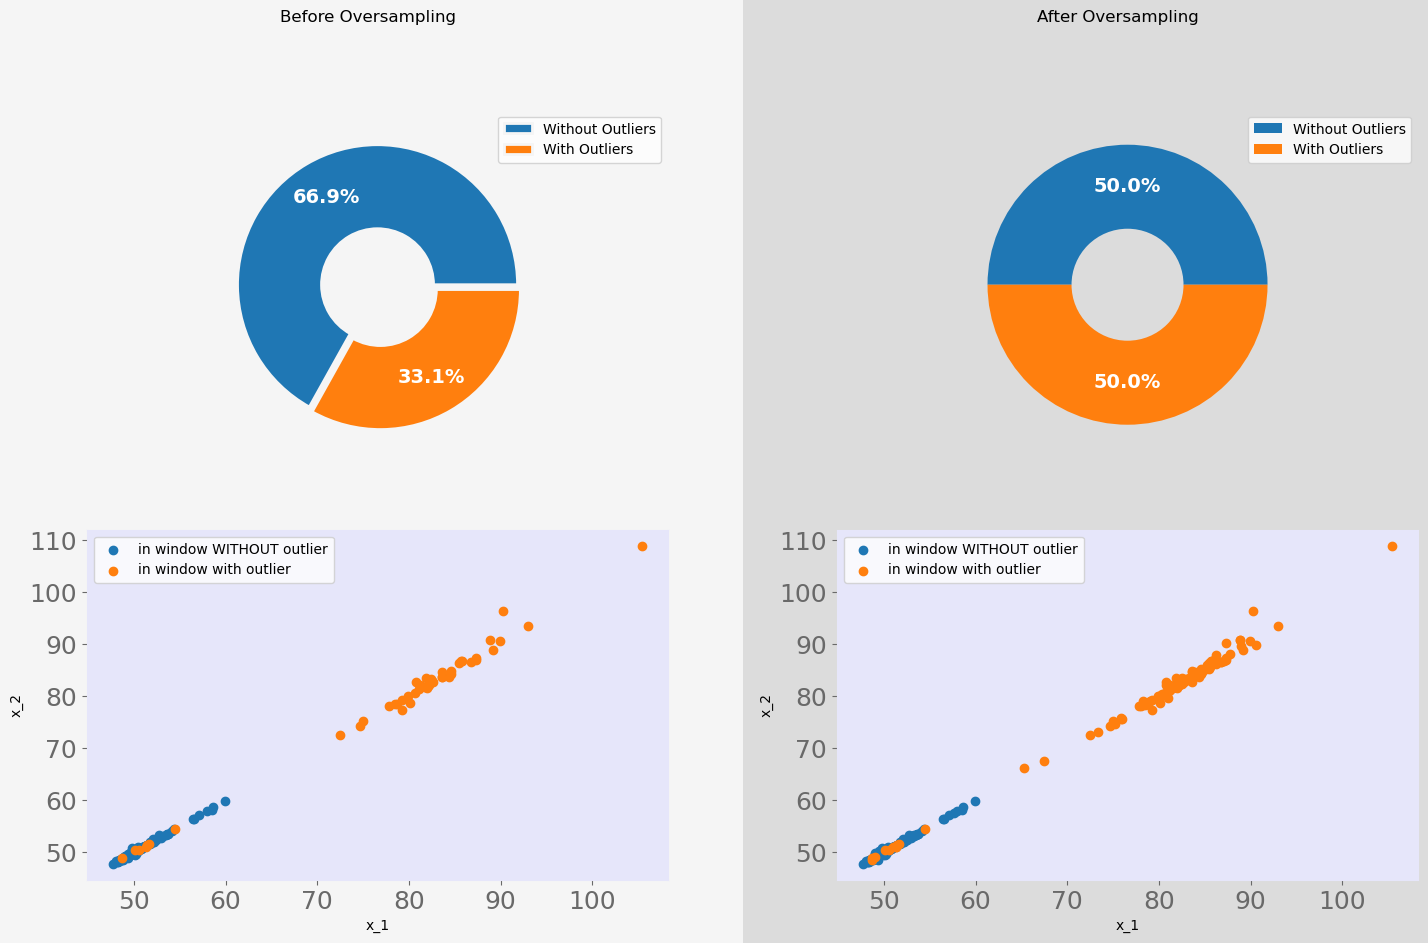

In [232]:
m_data_modeling.plot_class_distribution()

[]

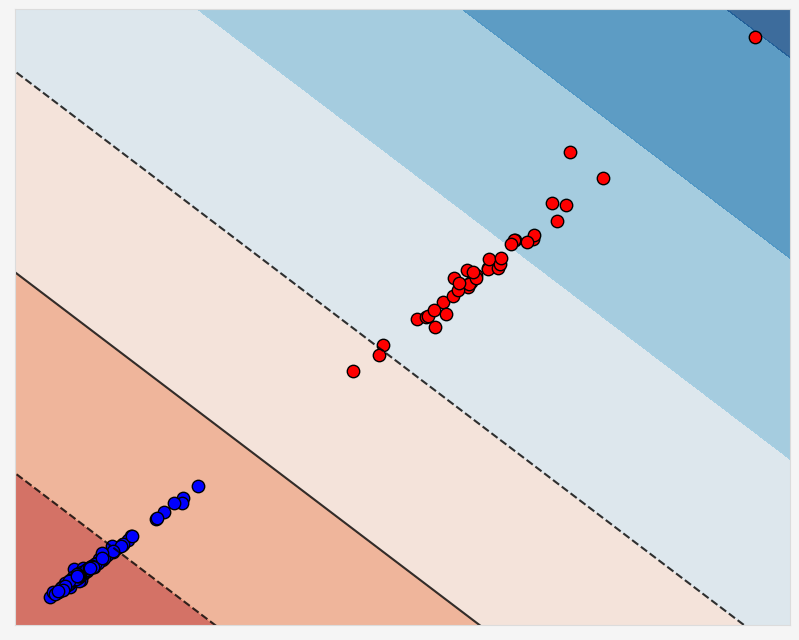

In [164]:
fg = plt.figure(figsize=(10,8), facecolor=PlotProperties.figFaceColor.value) 
ax = plt.subplot(1,1,1)
format_axis(ax)

m_model = ClassificationModels.supportVectorMachine
X_data = train_data[0]
y_data = train_data[1]
y_pred = m_data_modeling.make_prediction(X_data=X_data, with_model=m_model)

m_data_modeling.plot_decision_surface_boundary(
    model = m_model, 
    ax = ax,
    plot_boundary = True,
    #plot_support_vectors = True #only for SVM
)
m_data_modeling.plot_scaled_dataset(
    mdata = [X_data, y_pred], 
    ax=ax,
    plt_size=80
)
#ax.grid(True)
ax.set_xticks([])
ax.set_yticks([])

##### Comparing Models

/Users/steve/.local/lib/python3.9/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: No contour levels were found within the data range.
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/Users/steve/.local/lib/python3.9/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: No contour levels were found within the data range.
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/Users/steve/.local/lib/python3.9/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: No contour levels were found within the data range.
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/Users/steve/.local/lib/python3.9/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: No contour levels were found within the data range.
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


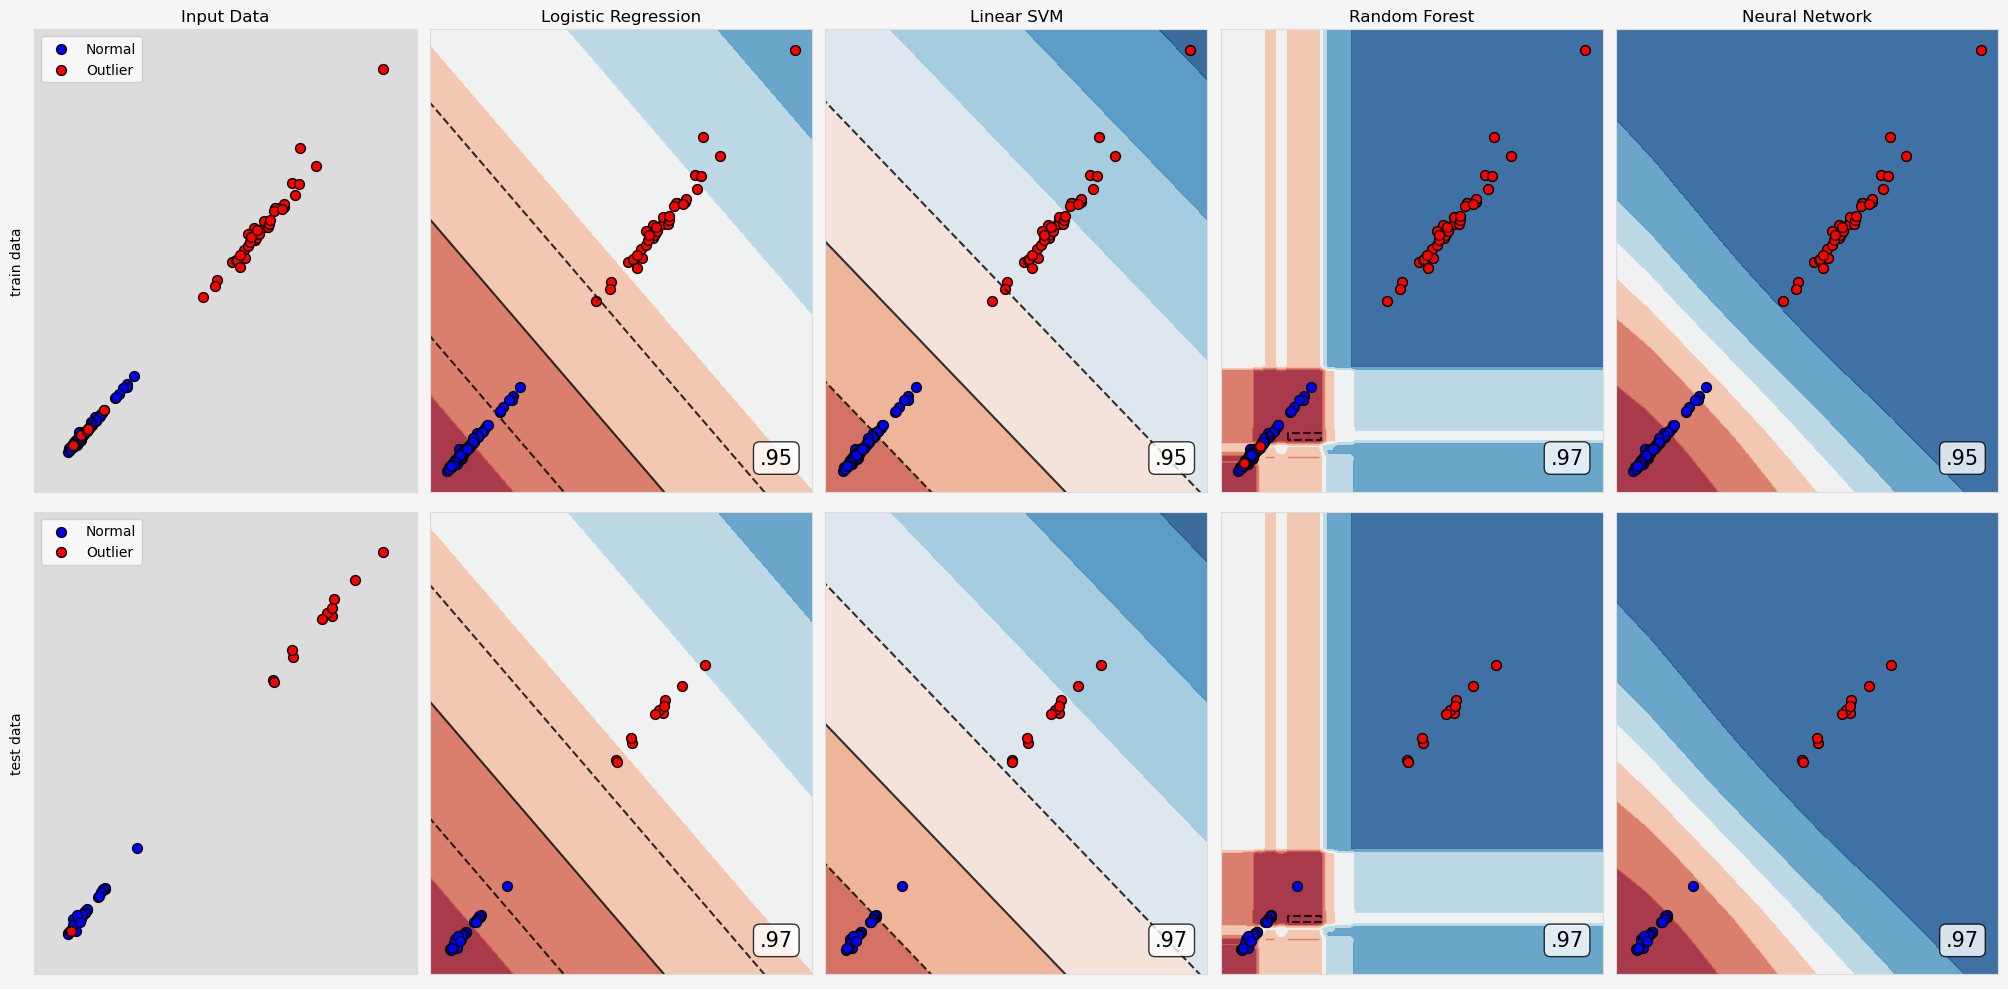

In [231]:
fg = m_data_modeling.plot_models_compared(
    models=[
        ClassificationModels.logisticRegression,
        ClassificationModels.supportVectorMachine,
        ClassificationModels.randomForest,
        ClassificationModels.neuralNetwork
    ]
)
fg.set_size_inches(20,10)

##### Evaluating the Models

In [229]:
# Making predictions for a set of input test data 
m_data_modeling.make_prediction(X_data=test_data[0][22:26], with_model=ClassificationModels.logisticRegression)

array([1., 0., 1., 0.])

In [230]:
train_score,test_score = m_data_modeling.evaluate_model(ClassificationModels.logisticRegression)
train_score, test_score 

(0.9495798319327731, 0.9722222222222222)

##### Confusion Matrices of Models

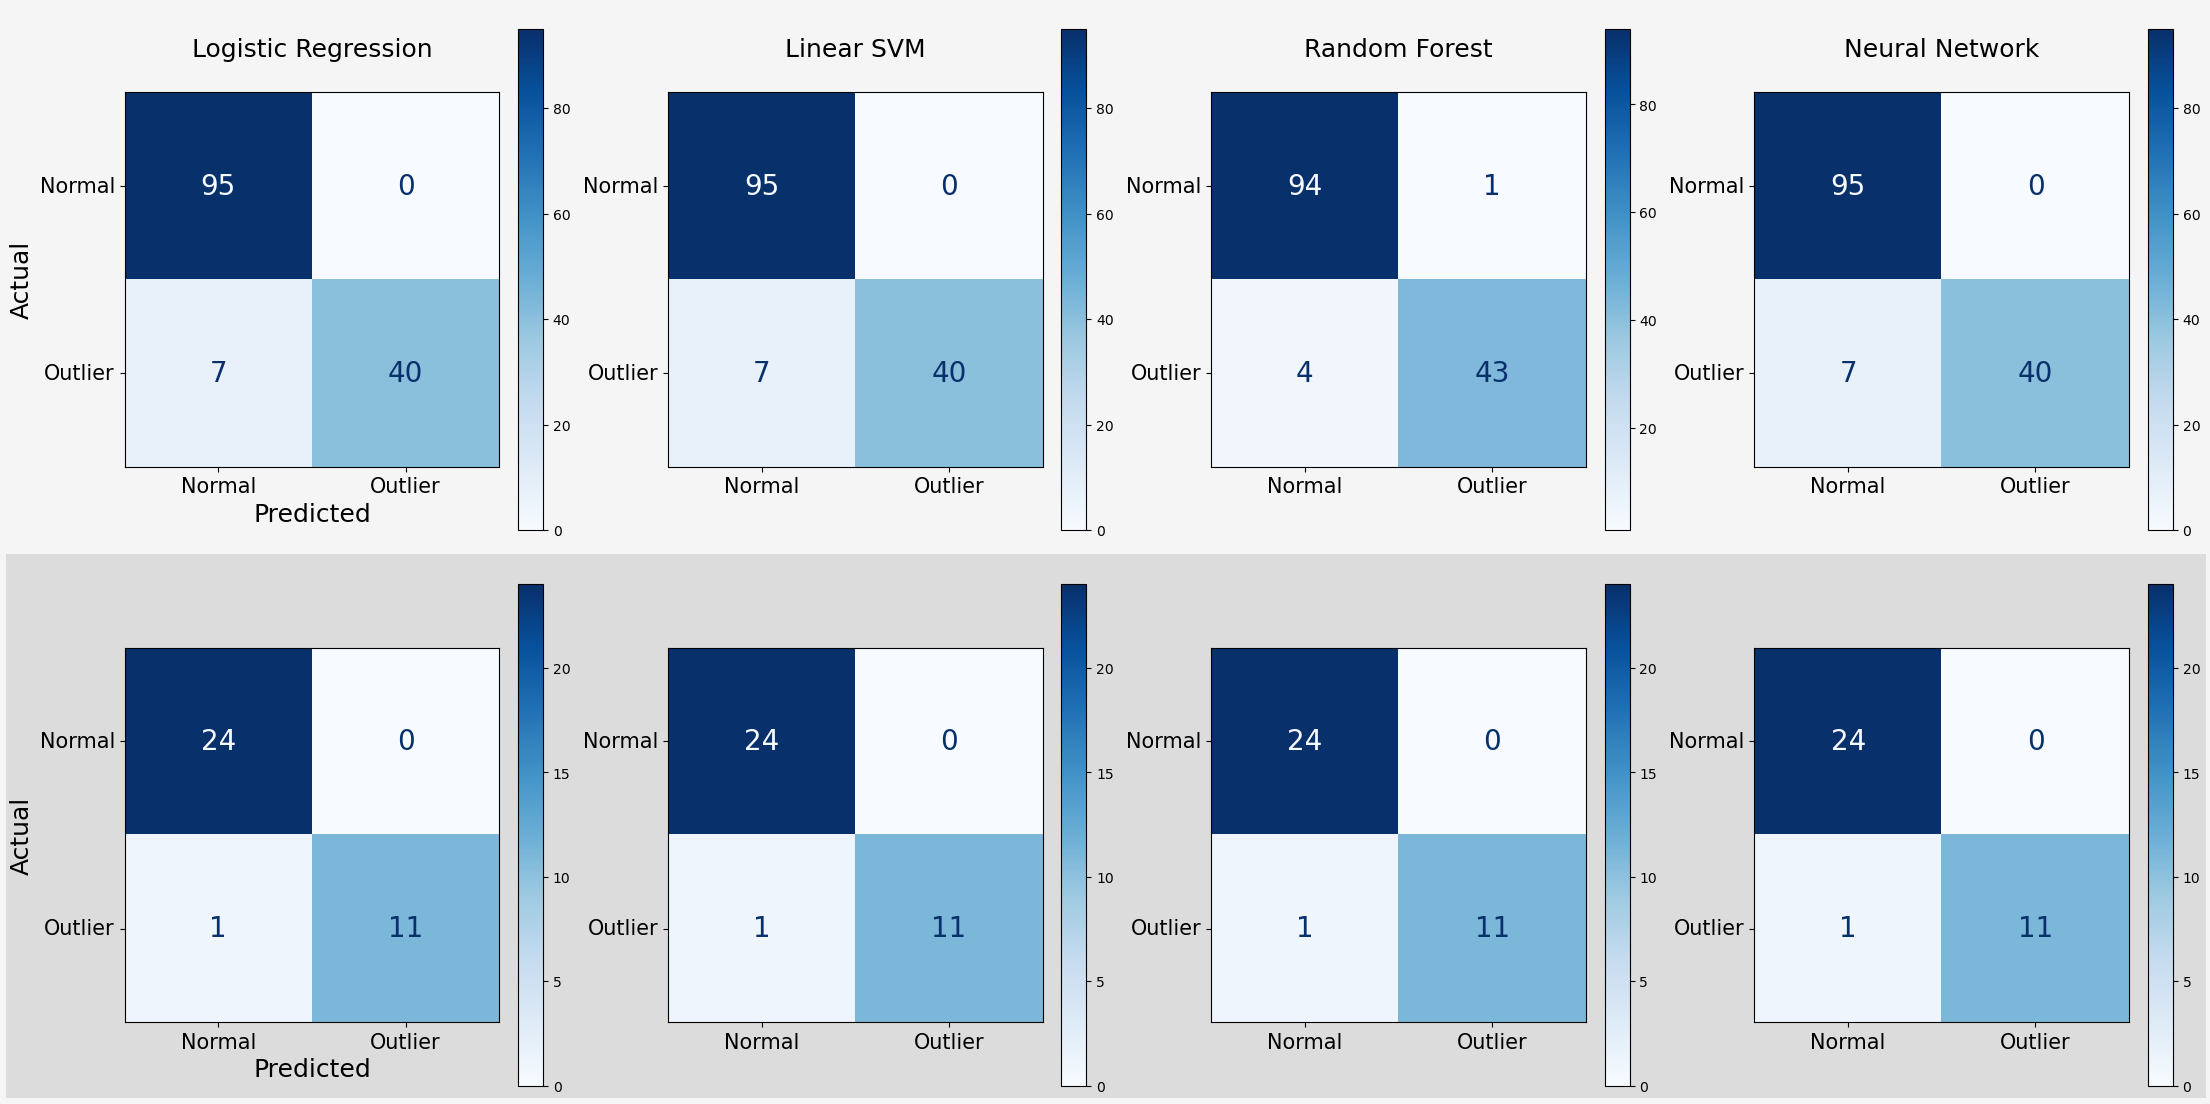

In [228]:
fg = m_data_modeling.plot_confusion_matrices_compared()
#fg.set_facecolor('g')
fg.set_size_inches(22,11)